## Analysis of flat10MIP output

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/work/aswann/conda-envs/xcdat_plus/lib/python3.11/site-packages/xarray/core/options.py:121: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM

MPI-ESM1-2-LR also did the experiments but I don't see any ouptut on NIRD

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr by year YYY, continues at zero emissions until 200 years past flat10

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella)
I tried to find matching grid files but none of the GISS models from CMIP6 appear to have the same resolution as the data from flat10

In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist= ['ACCESS-ESM1-5',  
            'CESM2',  
            'CNRM-ESM2-1',  
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM']

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

# initialize a dictionary to hold all of the data
data_dict={}

varlist=['cVeg', 'cLitter', 'cSoil', 'nbp'] #, 'gpp', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
unitslist=['kg m-2','kg m-2','kg m-2','']

# there seems to be a problem with ra for NorESM

In [3]:
# other info that I don't think is necessary - delete later

# python dislikes filenames with dashes
modellist_safe = ['ACCESS',
                  'CESM2',
                  'CNRM',
                  'GFDL',
                  'GISS',
                  'NorESM2']

caltype = ['DatetimeProlepticGregorian',
           'DatetimeNoLeap',
           'DatetimeGregorian',
           'DatetimeNoLeap',
           'year',
           'DatetimeNoLeap']

startdate = [101, 1, 1850, 1, 1850, 1850]


### Load grid info

In [4]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        print(model +' getting grid info')
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

        # add to the dictionary
        data_dict[model +'_areacella'] = areacella
        data_dict[model +'_landfrac'] = landfrac

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
CNRM-ESM2-1 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 does not have grid info
NorESM2-LM getting grid info


### Load data

In [5]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']


# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
            if 'nep' in dsmerge_f:
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep')
                
            # check units and convert if necessary - at the moment this is just CESM for carbon variables
            #if ds[veg].units != unitslist[v]:
                # the unit does not match what we expect, 
                # convert the unit and update the metadata
            # At the moment this only applies to CESM, but should catch the CESM units and not others
            # flux variables
            # test first to see if the variable exists. nbp is missnamed in one model
            if var in dsmerge_f: 
                if dsmerge_f[var].units == 'gC/m^2/s':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                # stock variables
                elif dsmerge_f[var].units == 'gC/m^2':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2'
                    
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                else:
                    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray
            
            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                dsmerge_v['cTot'] = dsmerge_v['cVeg'] + dsmerge_v['cSoil'] + dsmerge_v['cLitter']
        
        # save output to a dictionary
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v


adding ACCESS-ESM1-5 flat10 to dict
adding ACCESS-ESM1-5 flat10_zec to dict
adding ACCESS-ESM1-5 flat10_cdr to dict
adding CESM2 flat10 to dict
adding CESM2 flat10_zec to dict
adding CESM2 flat10_cdr to dict
adding CNRM-ESM2-1 flat10 to dict
adding CNRM-ESM2-1 flat10_zec to dict
adding CNRM-ESM2-1 flat10_cdr to dict
adding GFDL-ESM4 flat10 to dict
adding GFDL-ESM4 flat10_zec to dict
adding GFDL-ESM4 flat10_cdr to dict
adding GISS_E2.1 flat10 to dict
adding GISS_E2.1 flat10_zec to dict
adding GISS_E2.1 flat10_cdr to dict
adding NorESM2-LM flat10 to dict
adding NorESM2-LM flat10_zec to dict
adding NorESM2-LM flat10_cdr to dict


In [6]:
dsmerge_v


<xarray.Dataset>
Dimensions:    (time: 2640, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1950-01-16 12:00:00 ... 2169-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1950-01-01 00:00:00 ... 2170-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.05 -89.05 ... 89.05 90.0
    lon_bnds   (time, lon, bnds) float64 -1.25 1.25 1.25 ... 356.2 356.2 358.7
    cVeg       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cLitter    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cSoil      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cTot       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1851-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               cVeg
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/65085165-e204-43d5-b3e4-20e85166f14c

In [7]:
# checking units
var='nbp'
for model in modellist[1:]:
    arg=data_dict[model +'_flat10']
    print(model +' ' +var +': ' +arg[var].units)


CESM2 nbp: kg m-2 s-1
CNRM-ESM2-1 nbp: kg m-2 s-1
GFDL-ESM4 nbp: kg m-2 s-1
GISS_E2.1 nbp: kg m-2 s-1
NorESM2-LM nbp: kg m-2 s-1


## Define functions

In [8]:
def select_time_slice(dataset, startyear, endyear):
    """
    Selects the years between start year and end year
    of data from an xarray dataset.
    start year references 0 as the first year
    
    Args:
    - dataset: xarray dataset containing the time dimension
    
    Returns:
    - time_slice: xarray dataset containing the years of data between startyear and endyear

    Example usage:
    Assuming you have a list of xarray datasets called 'datasets'
    first_10_years_datasets = [select_first_10_years(dataset,startyear,endyear) for dataset in datasets]
    alternatively just retrieve a time slice for one dataset at a time
    """
    
    # Check if the dataset has a dimension labeled "time"
    if 'time' not in dataset.dims:
        # if the model is GISS, then it does not have a cftime time index 
        # and instead just an index of years
        time_coord = dataset.year.values
        time_slice = dataset.sel(year=slice(time_coord[0] + startyear, time_coord[0] + endyear))

    else:
        # model uses cftime
        # Extract the time coordinate from the dataset
        time_coord = dataset.time.values
        
        # Determine the calendar type of the dataset
        calendar_type = time_coord[0].calendar
        
        # Calculate the end date for the first 10 years based on the calendar type
        if calendar_type in ['standard', 'gregorian', 'proleptic_gregorian']:
            start_date = cftime.DatetimeGregorian(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeGregorian(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type == 'noleap':
            start_date = cftime.DatetimeNoLeap(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeNoLeap(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type == '365_day':
            start_date = cftime.Datetime360Day(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.Datetime360Day(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        # Add more conditions for other calendar types if needed
        
        # Select the time slice
        time_slice = dataset.sel(time=slice(start_date, end_date))
    
    return time_slice


In [9]:
lengthoftime = len(data_dict['CESM2_flat10'].time)
lengthoftime

2520

In [10]:
def plot_all_models_one_deltavar(var, run, modellist):

    """
    Plots an array of maps for the experiment defined by run, 
    and variable defined by var for each model in modellist
    
    Args:
    - modellist: a list of model names for which data is contained in data_dict
    - var: the name of the variable to plot
    - run: the name of the run to plot, where data is in data_dict
    
    Returns:
    - a figure with an array of maps of the change in var from the last 10
    years compared to the first 10 years of the experiment
    for flat10 it looks at year 100 vs year 0

    """
    
    fig = plt.figure(figsize=(12,14))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print(model)    
        # create datasets for each model + experiment combination + variable
        dsl=data_dict[model +'_' +run]
        ds=dsl[var]
        
        ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())

    #    if model == 'GISS_E2.1':
    #        arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
    #    else:
    #        arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))


        # total length of time series
        ds
        firstyears = select_time_slice(ds, 0, 9)
        if run=='flat10':
            lastyears = select_time_slice(ds, 90, 99)
        else:
            lastyears = select_time_slice(ds, 190, 199)


        # one model does not have a cftime time index, and uses year instead
        if 'time' not in ds.dims:
            arg=lastyears.mean(dim='year')-firstyears.mean(dim='year')
        else:
            arg=lastyears.mean(dim='time')-firstyears.mean(dim='time')
        
        fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
    
        fg.axes.coastlines()
        plt.title(model)
    
    # add a title over the whole figure with the name of the run
    fig.suptitle(run)
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [11]:
def plot_all_models_zonal_by_time(var, run, modellist):

    """
    Plots an array of zonal profiles over time
    for the experiment defined by run, 
    and variable defined by var for each model in modellist
    
    Args:
    - modellist: a list of model names for which data is contained in data_dict
    - var: the name of the variable to plot
    - run: the name of the run to plot, where data is in data_dict
    
    Returns:
    - a figure with an array of zonal by time plots of var
    """   
   
    #def plot_all_models_one_var(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,12))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
    
        # create datasets for each model + experiment combination + variable
        dsl=data_dict[model +'_' +run]
        ds=dsl[var]
        
        ax=plt.subplot(3,2,m+1)

        arg=(ds.mean(dim='lon'))
        
        if 'time' not in ds.dims:
            fg = arg.plot(x='year',cmap='YlGn')
        else:    
            fg = arg.plot(x='time',cmap='YlGn')
        
        plt.ylim([-90, 90])
        
        plt.title(model)
    
    fig.suptitle(run)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [12]:
def plot_zonal_delta_allexp_one_var(var, modellist):
    """
    Plots an array of zonal profiles over time
    for all experiments relative to the first 10 years of flat10, 
    and variable defined by var for each model in modellist
    
    Args:
    - modellist: a list of model names for which data is contained in data_dict
    - var: the name of the variable to plot
    
    Returns:
    - a figure with an array of zonal by time plots of var relative to the first 10 
    years of flat10
    """   
   

    # --set up the subplots
    # Calculate the number of rows
    num_rows = (len(modellist)*3 + 2) // 3  # Ceiling division to ensure we have enough rows
    
    # Create a figure and axis objects
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    
    # Flatten the axis array to iterate easily
    #axs = axs.flatten()
    # to use, refer to one index in axs: ax = axs[i]
        
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print('Plotting ' +model)
        # create datasets for each model + experiment combination + variable
        # these are already subset to the correct time blocks
        run=runlist[0]
        ds = data_dict[modellist[m] +'_' +runlist[0]]
        ###if var in ds:
        ds0 = select_time_slice(ds[var], 0, 99)
        
        #find average of first 10 years
        dsften = select_time_slice(ds[var], 0, 10)
        if 'time' not in ds.dims:
            dsinit=dsften.mean(dim='year')
        else:
            dsinit=dsften.mean(dim='time')
        
        run=runlist[1]
        ds = data_dict[modellist[m] +'_' +runlist[1]]
        ds1 = select_time_slice(ds[var], 0, 199)
        
        
        run=runlist[2]
        ds = data_dict[modellist[m] +'_' +runlist[2]]
        ds2 = select_time_slice(ds[var], 0, 199)
        
        
        #-- now plot
        
        #-flat10
        #ax=plt.subplot(6,3,1+(m*3))
        ax = axs[m, 0]
        
        if 'time' not in ds.dims:
            fg = (ds0-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        else:
            fg = (ds0-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        
        ax.set_ylabel(model)
        plt.ylim([-90, 90])
        
        if m==0:
            plt.title(runlist[0])
        
        #-flat10zec
        #ax=plt.subplot(6,3,1+(m*4))
        ax = axs[m, 1]
        
        if 'time' not in ds.dims:
            fg = (ds1-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        else:
            fg = (ds1-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
    
        if m==0:
            plt.title(runlist[1])
        
        #-flat10zec
        #ax=plt.subplot(6,3,1+(m*5))
        ax = axs[m, 2]
        
        if 'time' not in ds.dims:
            fg = (ds2-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG', 
                                                   ax=ax)
        else:
            fg = (ds2-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                                   ax=ax)
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
    
        if m==0:
            plt.title(runlist[2])
        
        
    #    fig.suptitle(model)
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +var +'_delta_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [13]:
def plot_zonal_delta_allexp_one_var_flux(var, modellist):
    """
    Plots an array of zonal profiles over time - FOR FLUX VARIABLES
    for all experiments relative to the first 10 years of flat10, 
    and variable defined by var for each model in modellist
    
    Args:
    - modellist: a list of model names for which data is contained in data_dict
    - var: the name of the variable to plot
    
    Returns:
    - a figure with an array of zonal by time plots of var relative to the first 10 
    years of flat10
    """   
   

    # --set up the subplots
    # Calculate the number of rows
    num_rows = (len(modellist)*3 + 2) // 3  # Ceiling division to ensure we have enough rows
    
    # Create a figure and axis objects
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    
    # Flatten the axis array to iterate easily
    #axs = axs.flatten()
    # to use, refer to one index in axs: ax = axs[i]
        
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print('Plotting ' +model)
        # create datasets for each model + experiment combination + variable
        # these are already subset to the correct time blocks
        run=runlist[0]
        ds = data_dict[modellist[m] +'_' +runlist[0]]
        ds0 = select_time_slice(ds[var], 0, 99)
        
        #find average of first 10 years
        dsften = select_time_slice(ds[var], 0, 10)
        if 'time' not in ds.dims:
            dsinit=dsften.mean(dim='year')
        else:
            dsinit=dsften.mean(dim='time')
        
        run=runlist[1]
        ds = data_dict[modellist[m] +'_' +runlist[1]]
        ds1 = select_time_slice(ds[var], 0, 199)
        
        
        run=runlist[2]
        ds = data_dict[modellist[m] +'_' +runlist[2]]
        ds2 = select_time_slice(ds[var], 0, 199)
        
        
        #-- now plot
        
        #-flat10
        #ax=plt.subplot(6,3,1+(m*3))
        ax = axs[m, 0]
        
        if 'time' not in ds.dims:
            fg = (ds0).mean(dim='lon').plot(x='year',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        else:
            ds=ds0.resample(time='Y').mean(dim='time')
            fg = (ds).mean(dim='lon').plot(x='time',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        
        ax.set_ylabel(model)
        plt.ylim([-90, 90])
        
        if m==0:
            plt.title(runlist[0])
        
        #-flat10zec
        #ax=plt.subplot(6,3,1+(m*4))
        ax = axs[m, 1]
        
        if 'time' not in ds.dims:
            fg = (ds1).mean(dim='lon').plot(x='year',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        else:
            ds=ds1.resample(time='Y').mean(dim='time')
            fg = (ds).mean(dim='lon').plot(x='time',cmap='PiYG',
                                                   add_colorbar=False,
                                                   ax=ax)
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
    
        if m==0:
            plt.title(runlist[1])
        
        #-flat10zec
        #ax=plt.subplot(6,3,1+(m*5))
        ax = axs[m, 2]
        
        if 'time' not in ds.dims:
            fg = (ds2).mean(dim='lon').plot(x='year',cmap='PiYG', 
                                                   ax=ax)
        else:
            ds=ds2.resample(time='Y').mean(dim='time')
            fg = (ds).mean(dim='lon').plot(x='time',cmap='PiYG',
                                                   ax=ax)
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
    
        if m==0:
            plt.title(runlist[2])
        
        
    #    fig.suptitle(model)
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +var +'_delta_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

### Testing

In [14]:
# Test out a search path for one model and variabile
model = 'NorESM2-LM'
run = '*zec'
var='cSoil'


searchpath= outputdir +model +'/' +run +'/' +var +'*.nc'

filenamelist= glob.glob(searchpath)

#ds = xr.open_dataset(pathtofile)


filenamelist

['/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_214001-214912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_198001-198912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_208001-208912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_203001-203912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_201001-201912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoilSlow_Lmon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_196001-196912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_zec/cSoil_Emon_NorESM2-LM_flat10_zec_r1i1p1f1_gn_213001-213912.nc',
 '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10_

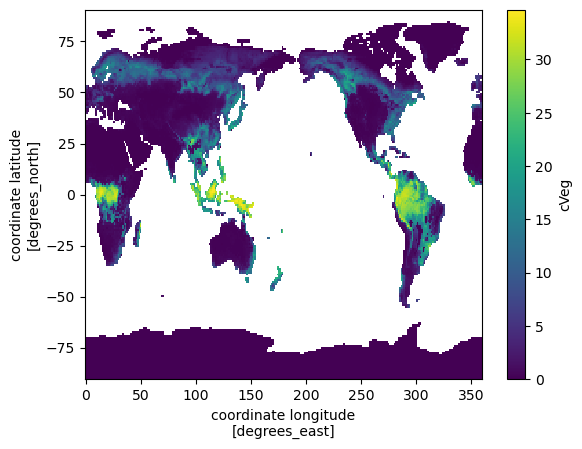

In [15]:
CESM2_flat10=data_dict['CESM2_flat10']
CESM2_flat10.cVeg.mean(dim='time').plot()


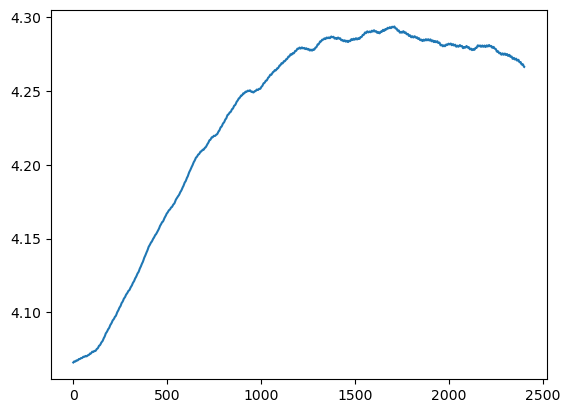

In [16]:
ACCESS_flat10=data_dict['ACCESS-ESM1-5_flat10']
plt.plot(ACCESS_flat10.cSoil.mean(dim=['lat','lon']).values)


# Plot data

## Land carbon budget over time

pools:  
cVeg, cLitter, cSoil

fluxes:  
nbp, npp, gpp, ra, rh



### Plot map of change in carbon on land
carbon on land = cVeg + cSoil + cLitter  

some models do not have cLitter?


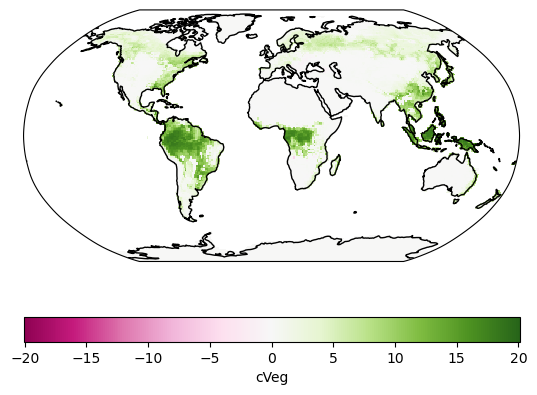

In [17]:
#--- plot one model using xarray.plot

CESM2_flat10=data_dict['CESM2_flat10']
# make the plot entirely with xarray.plot function

arg=(CESM2_flat10.cVeg[-23:-1,:,:].mean(dim='time')-CESM2_flat10.cVeg[0:23,:,:].mean(dim='time'))

fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
fg.axes.coastlines()



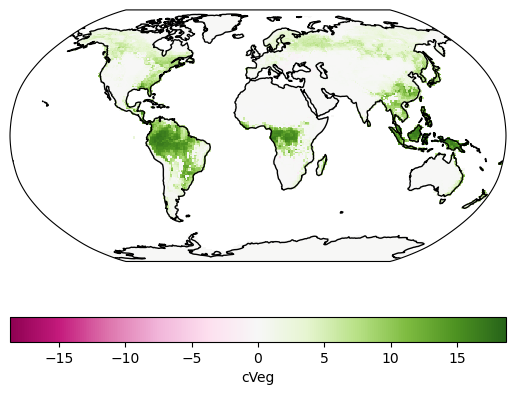

In [18]:
time1=select_time_slice(CESM2_flat10.cVeg, 0, 10)
time2=select_time_slice(CESM2_flat10.cVeg, 190, 200)
fg = (time2.mean(dim='time')-time1.mean(dim='time')).plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
fg.axes.coastlines()


In [19]:
ds=data_dict['GISS_E2.1_flat10']


# Determine the calendar type of the dataset
#calendar_type = time_coord[0].calendar

#time1=select_time_slice(ds.cVeg, 0, 10)

time_coord = ds.year.values

time_slice = ds.sel(year=slice(time_coord[0]+0, time_coord[0]+10))

time_slice


<xarray.Dataset>
Dimensions:  (lon: 144, lat: 90, year: 11)
Coordinates:
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * lat      (lat) float32 -90.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 90.0
  * year     (year) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    axyp     (lat, lon) float32 1.079e+09 1.079e+09 ... 1.079e+09 1.079e+09
    cVeg     (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    cLitter  (year, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    cSoil    (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    cTot     (year, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    nbp      (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [22]:
#arg=firsttimeentry.values


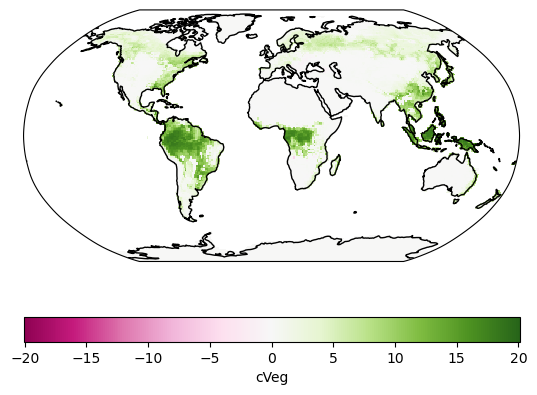

In [23]:
#--- plot one model using xarray.plot

CESM2_flat10=data_dict['CESM2_flat10']
# make the plot entirely with xarray.plot function


arg=(CESM2_flat10.cVeg[-23:-1,:,:].mean(dim='time')-CESM2_flat10.cVeg[0:23,:,:].mean(dim='time'))

fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
fg.axes.coastlines()

#### Use plotting function to plot maps from all models at once

ACCESS-ESM1-5
CESM2
CNRM-ESM2-1
GFDL-ESM4
GISS_E2.1
NorESM2-LM


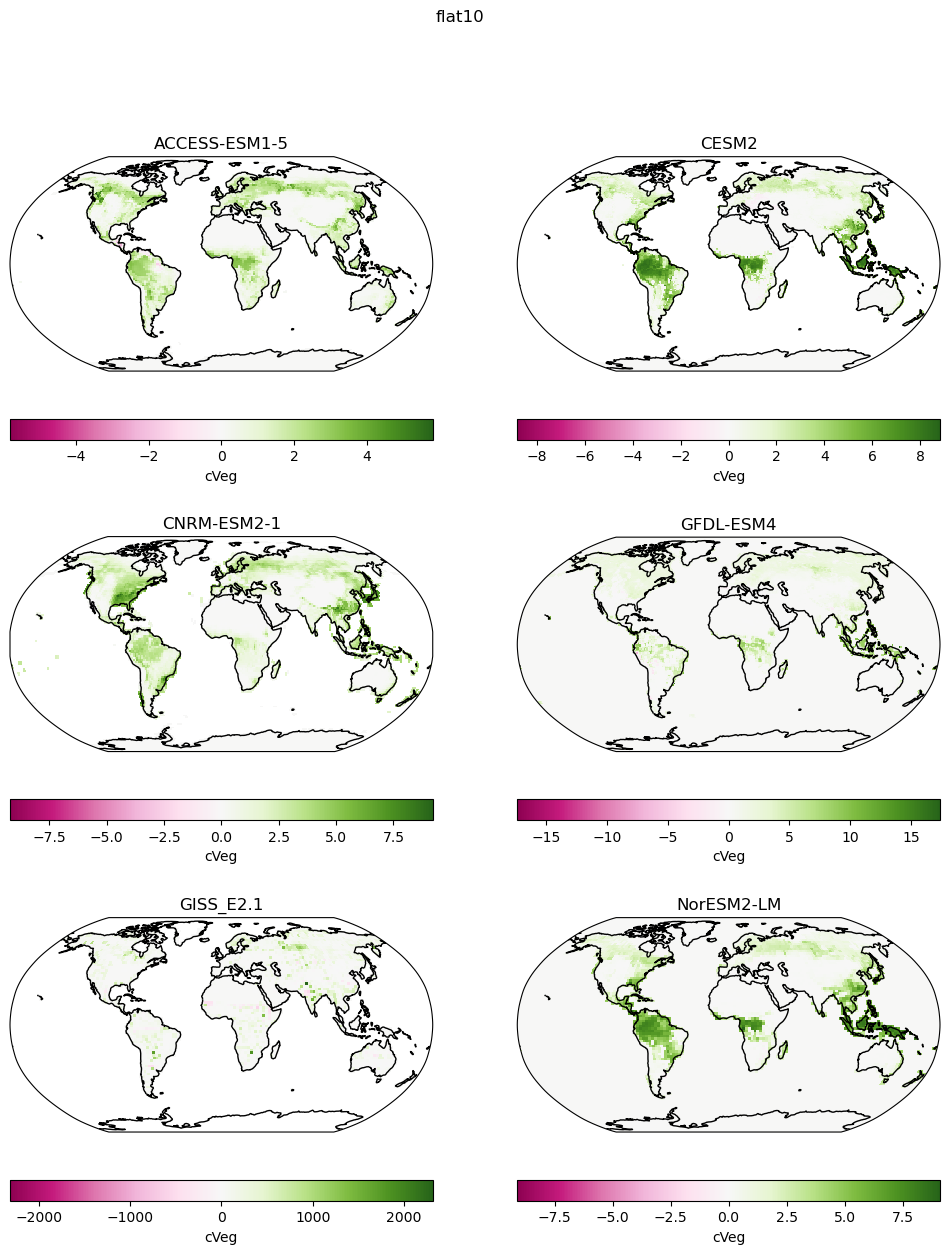

done saving file


In [24]:
# Plotting cVeg for flat10

run=runlist[0]
var='cVeg'

plot_all_models_one_deltavar(var, run, modellist)

ACCESS-ESM1-5
CESM2
CNRM-ESM2-1
GFDL-ESM4
GISS_E2.1
NorESM2-LM


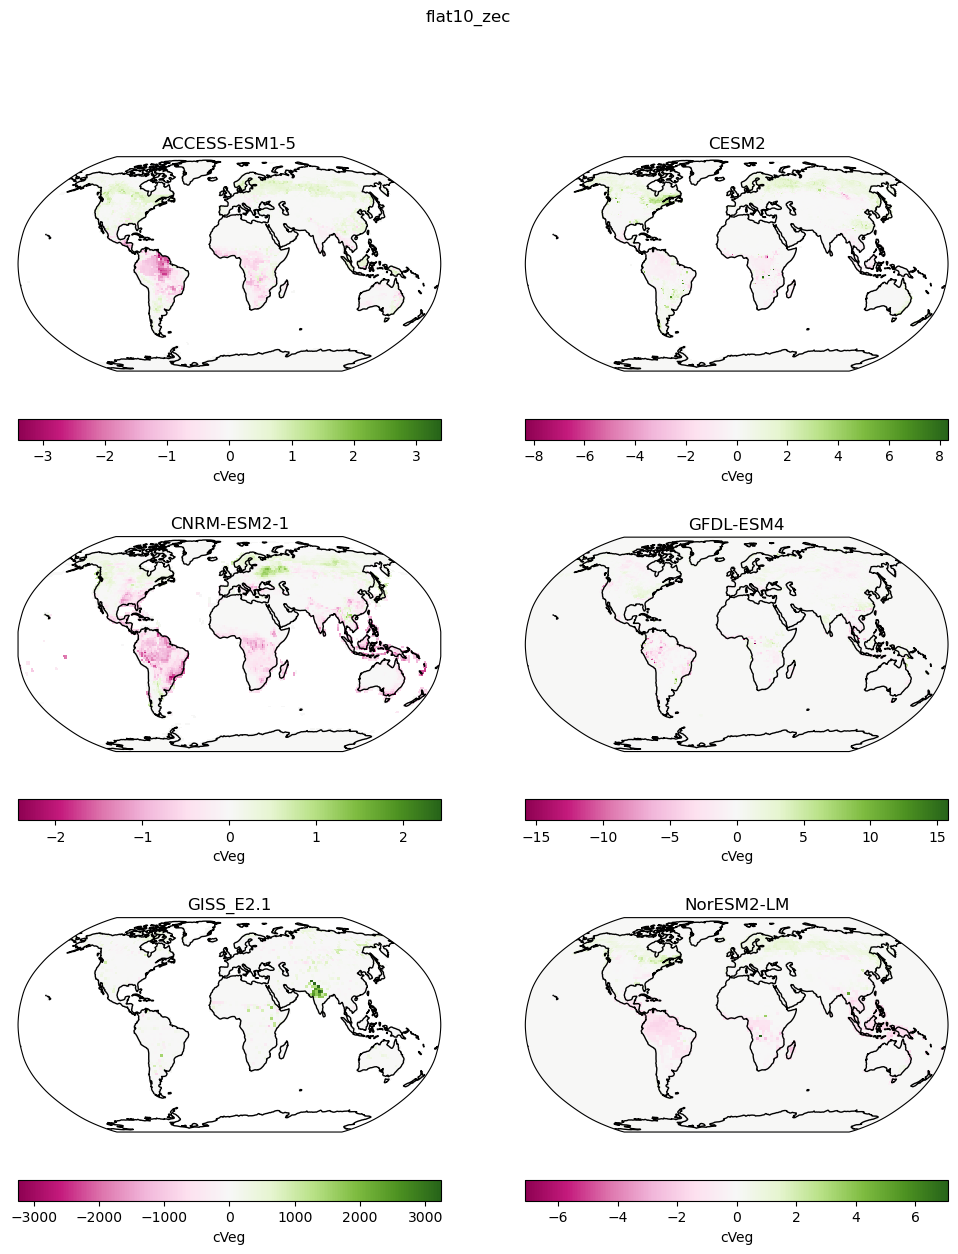

done saving file


In [25]:
# Plotting cVeg for flat10zec

run=runlist[1]
var='cVeg'

plot_all_models_one_deltavar(var, run, modellist)

ACCESS-ESM1-5
CESM2
CNRM-ESM2-1
GFDL-ESM4
GISS_E2.1
NorESM2-LM


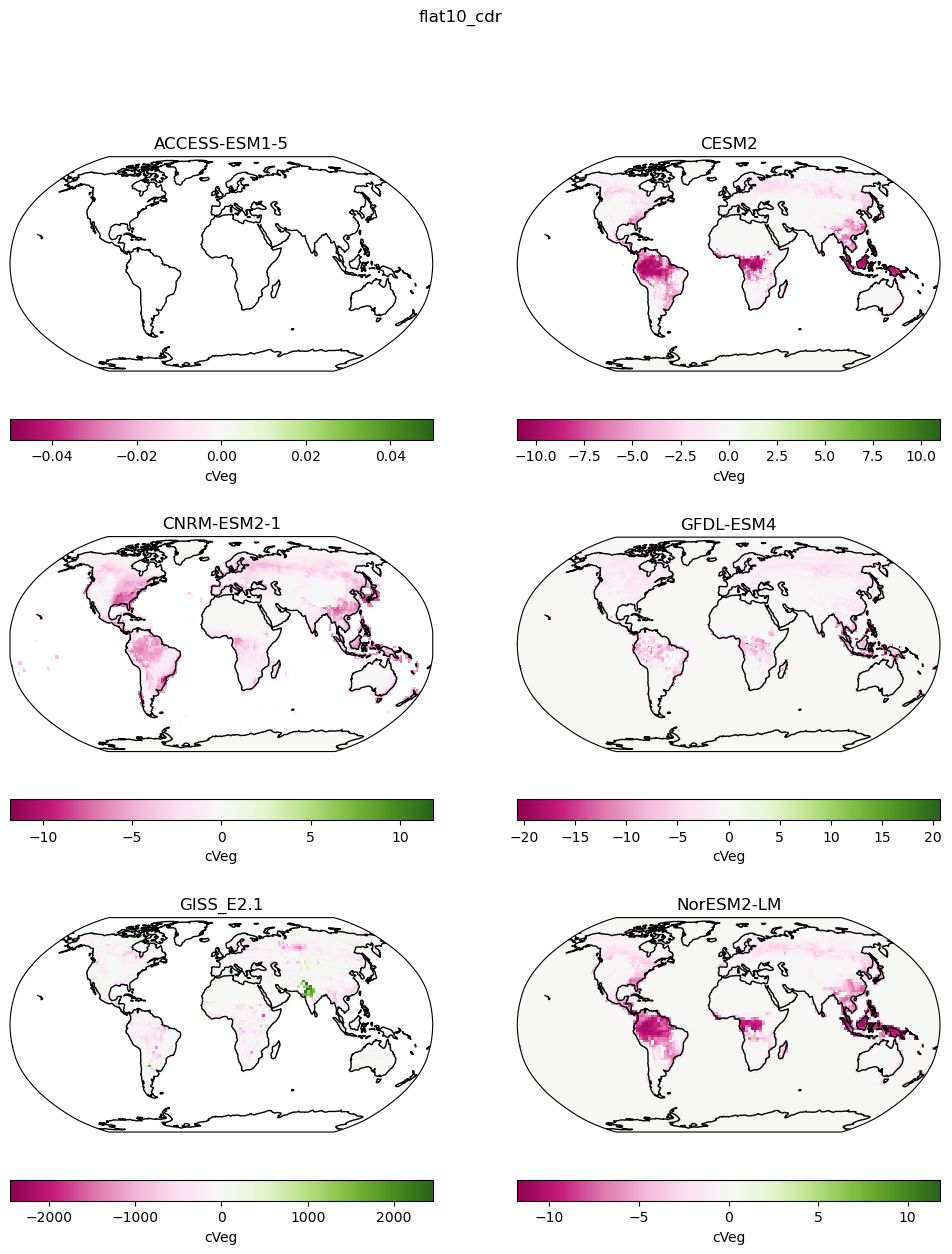

done saving file


In [26]:
# Plotting change in cVeg for flat10cdr

run=runlist[2]
var='cVeg'

plot_all_models_one_deltavar(var, run, modellist)

#### now zonal profiles

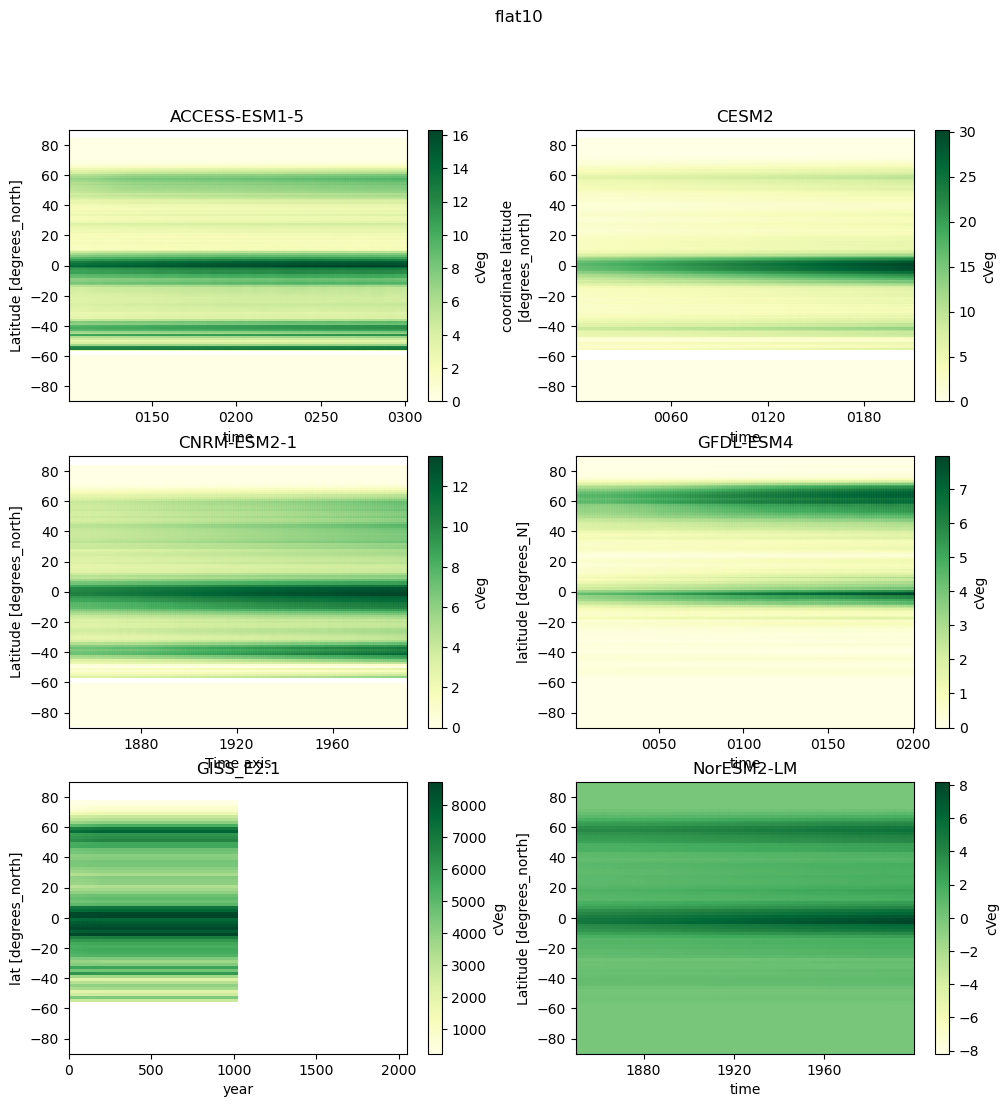

done saving file


In [27]:
# zonal by time plots
run=runlist[0]
var='cVeg'

plot_all_models_zonal_by_time(var, run, modellist)

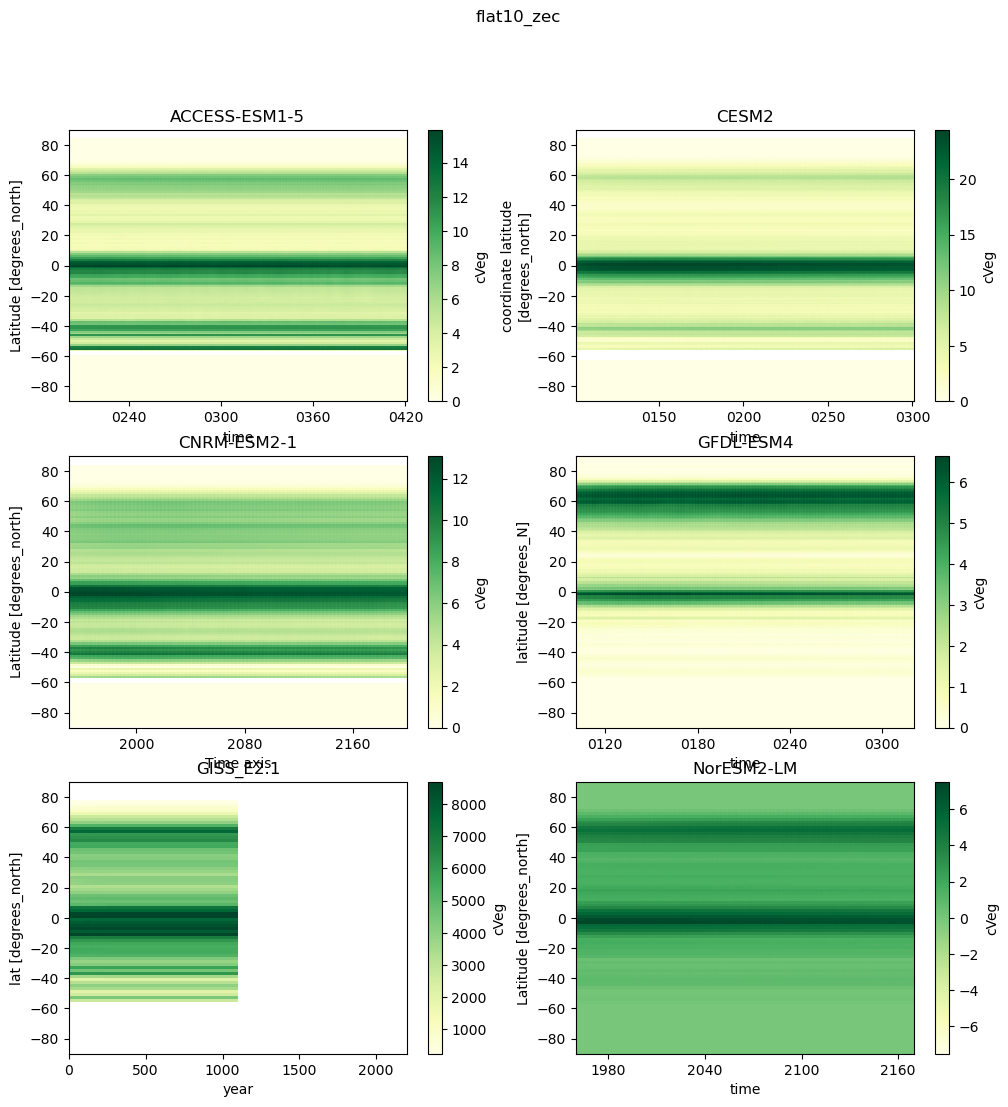

done saving file


In [28]:
# zonal by time plots
run=runlist[1]
var='cVeg'

plot_all_models_zonal_by_time(var, run, modellist)

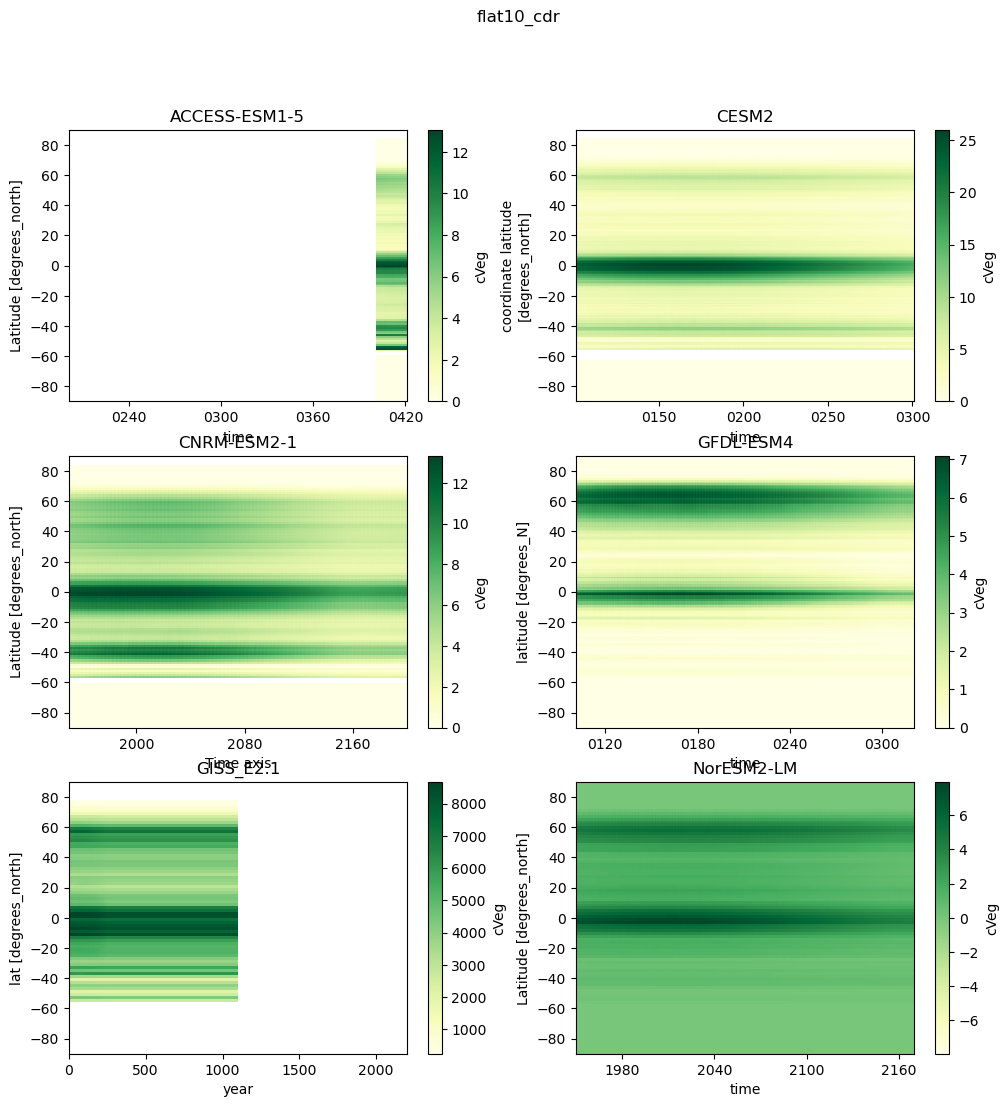

done saving file


In [29]:
# zonal by time plots
run=runlist[2]
var='cVeg'

plot_all_models_zonal_by_time(var, run, modellist)

Plotting ACCESS-ESM1-5
Plotting CESM2
Plotting CNRM-ESM2-1
Plotting GFDL-ESM4
Plotting GISS_E2.1
Plotting NorESM2-LM


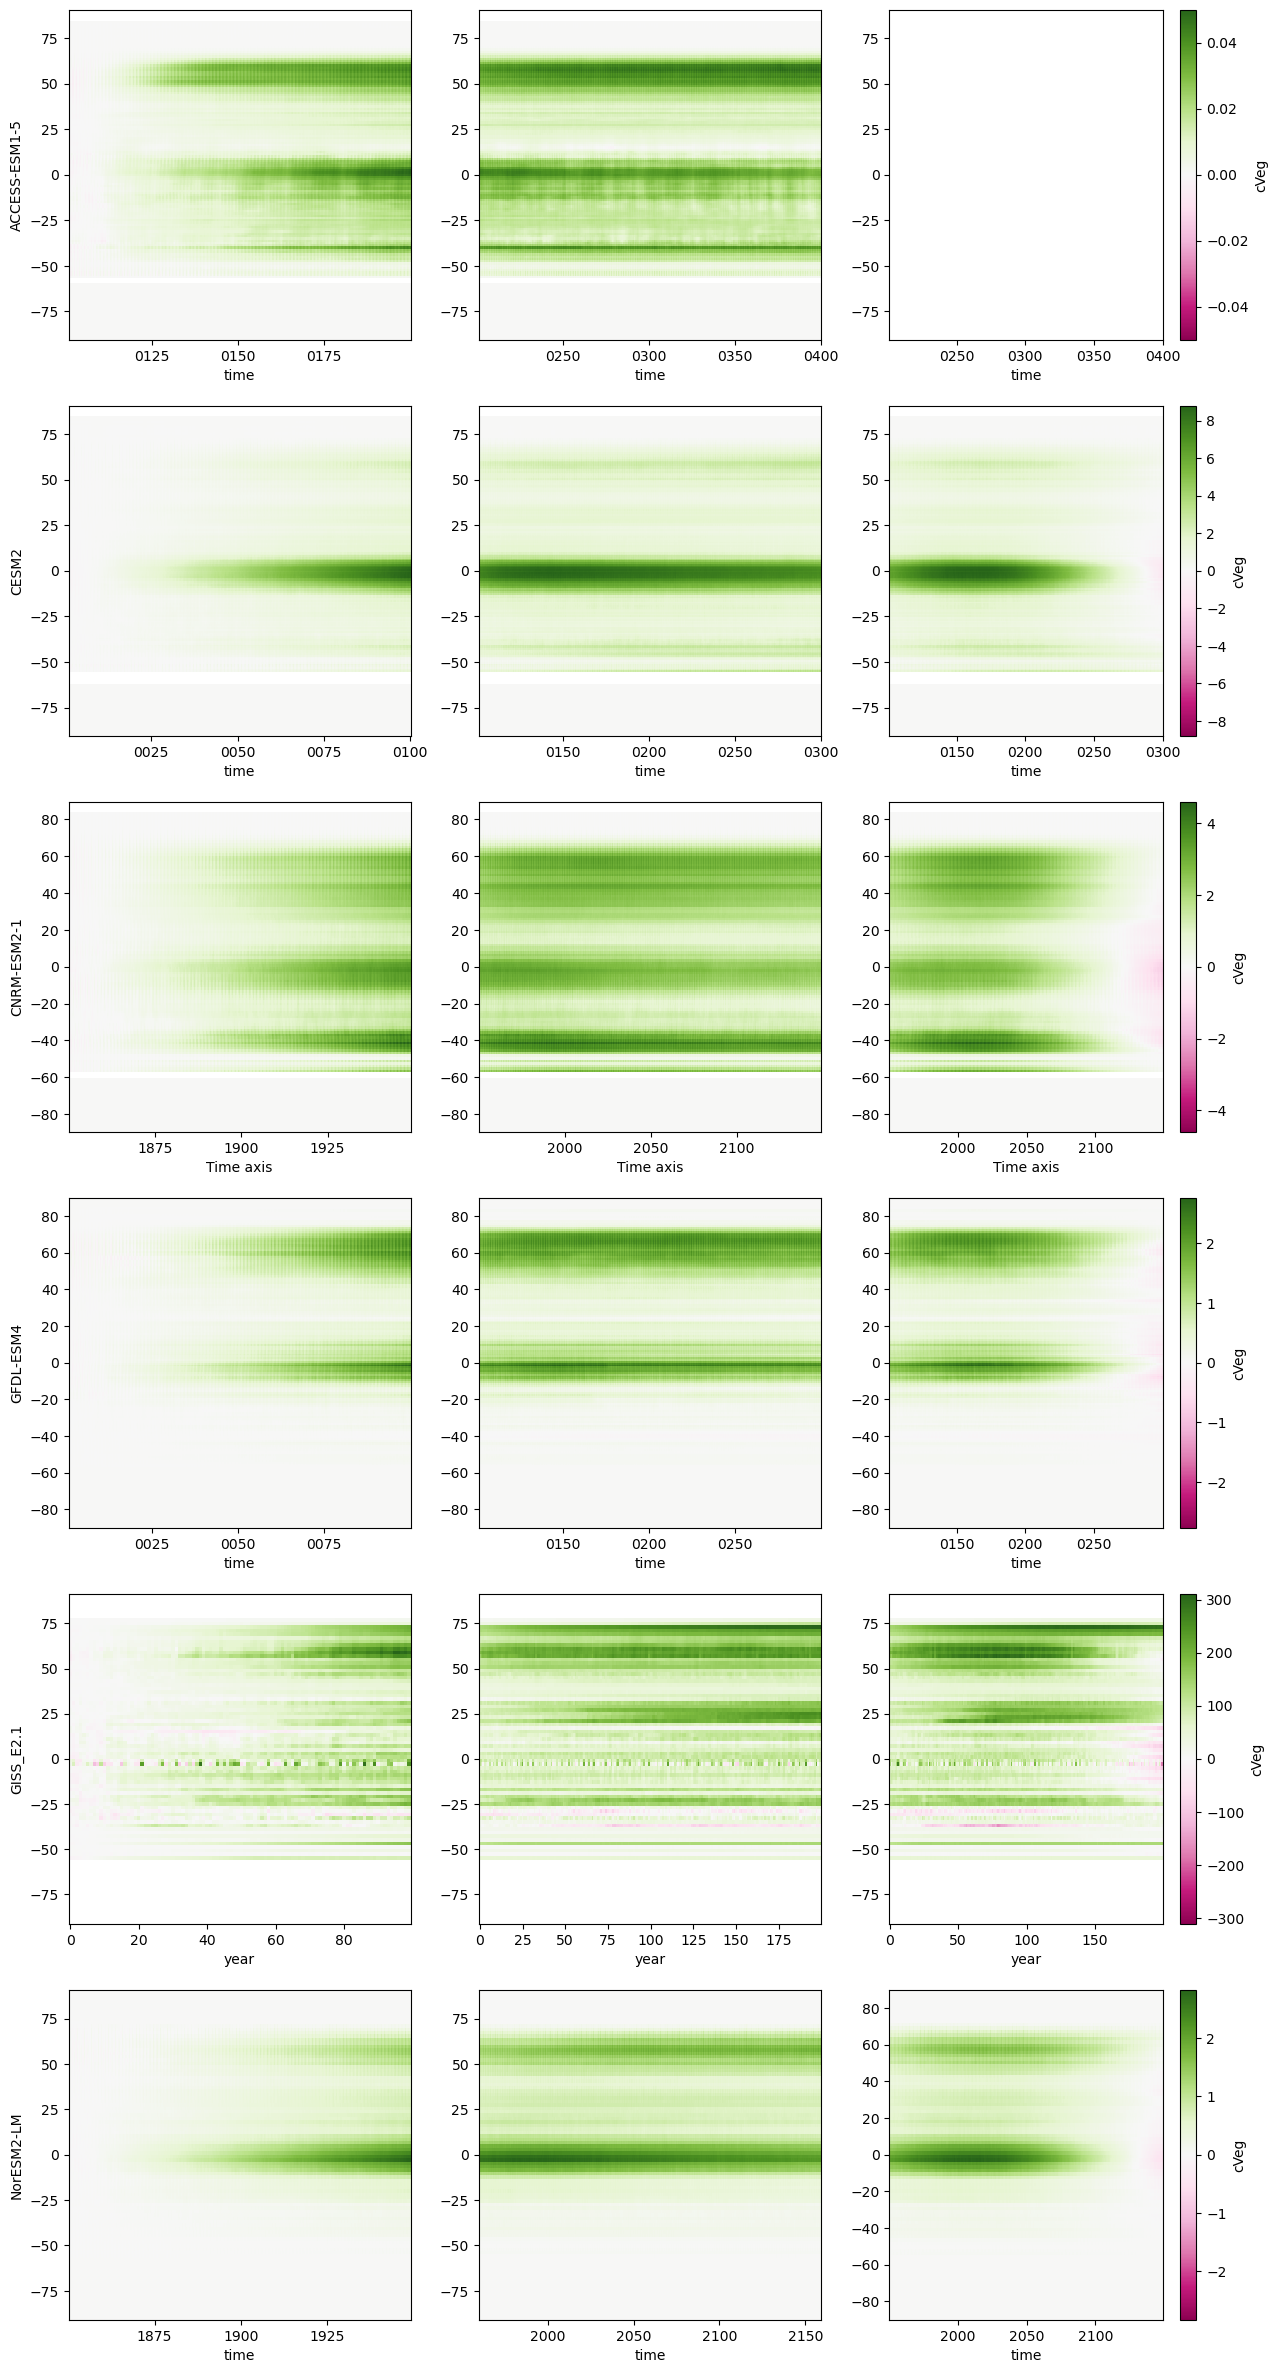

done saving file


In [30]:
plot_zonal_delta_allexp_one_var('cVeg', modellist)

Plotting ACCESS-ESM1-5
Plotting CESM2
Plotting CNRM-ESM2-1
Plotting GFDL-ESM4
Plotting GISS_E2.1
Plotting NorESM2-LM


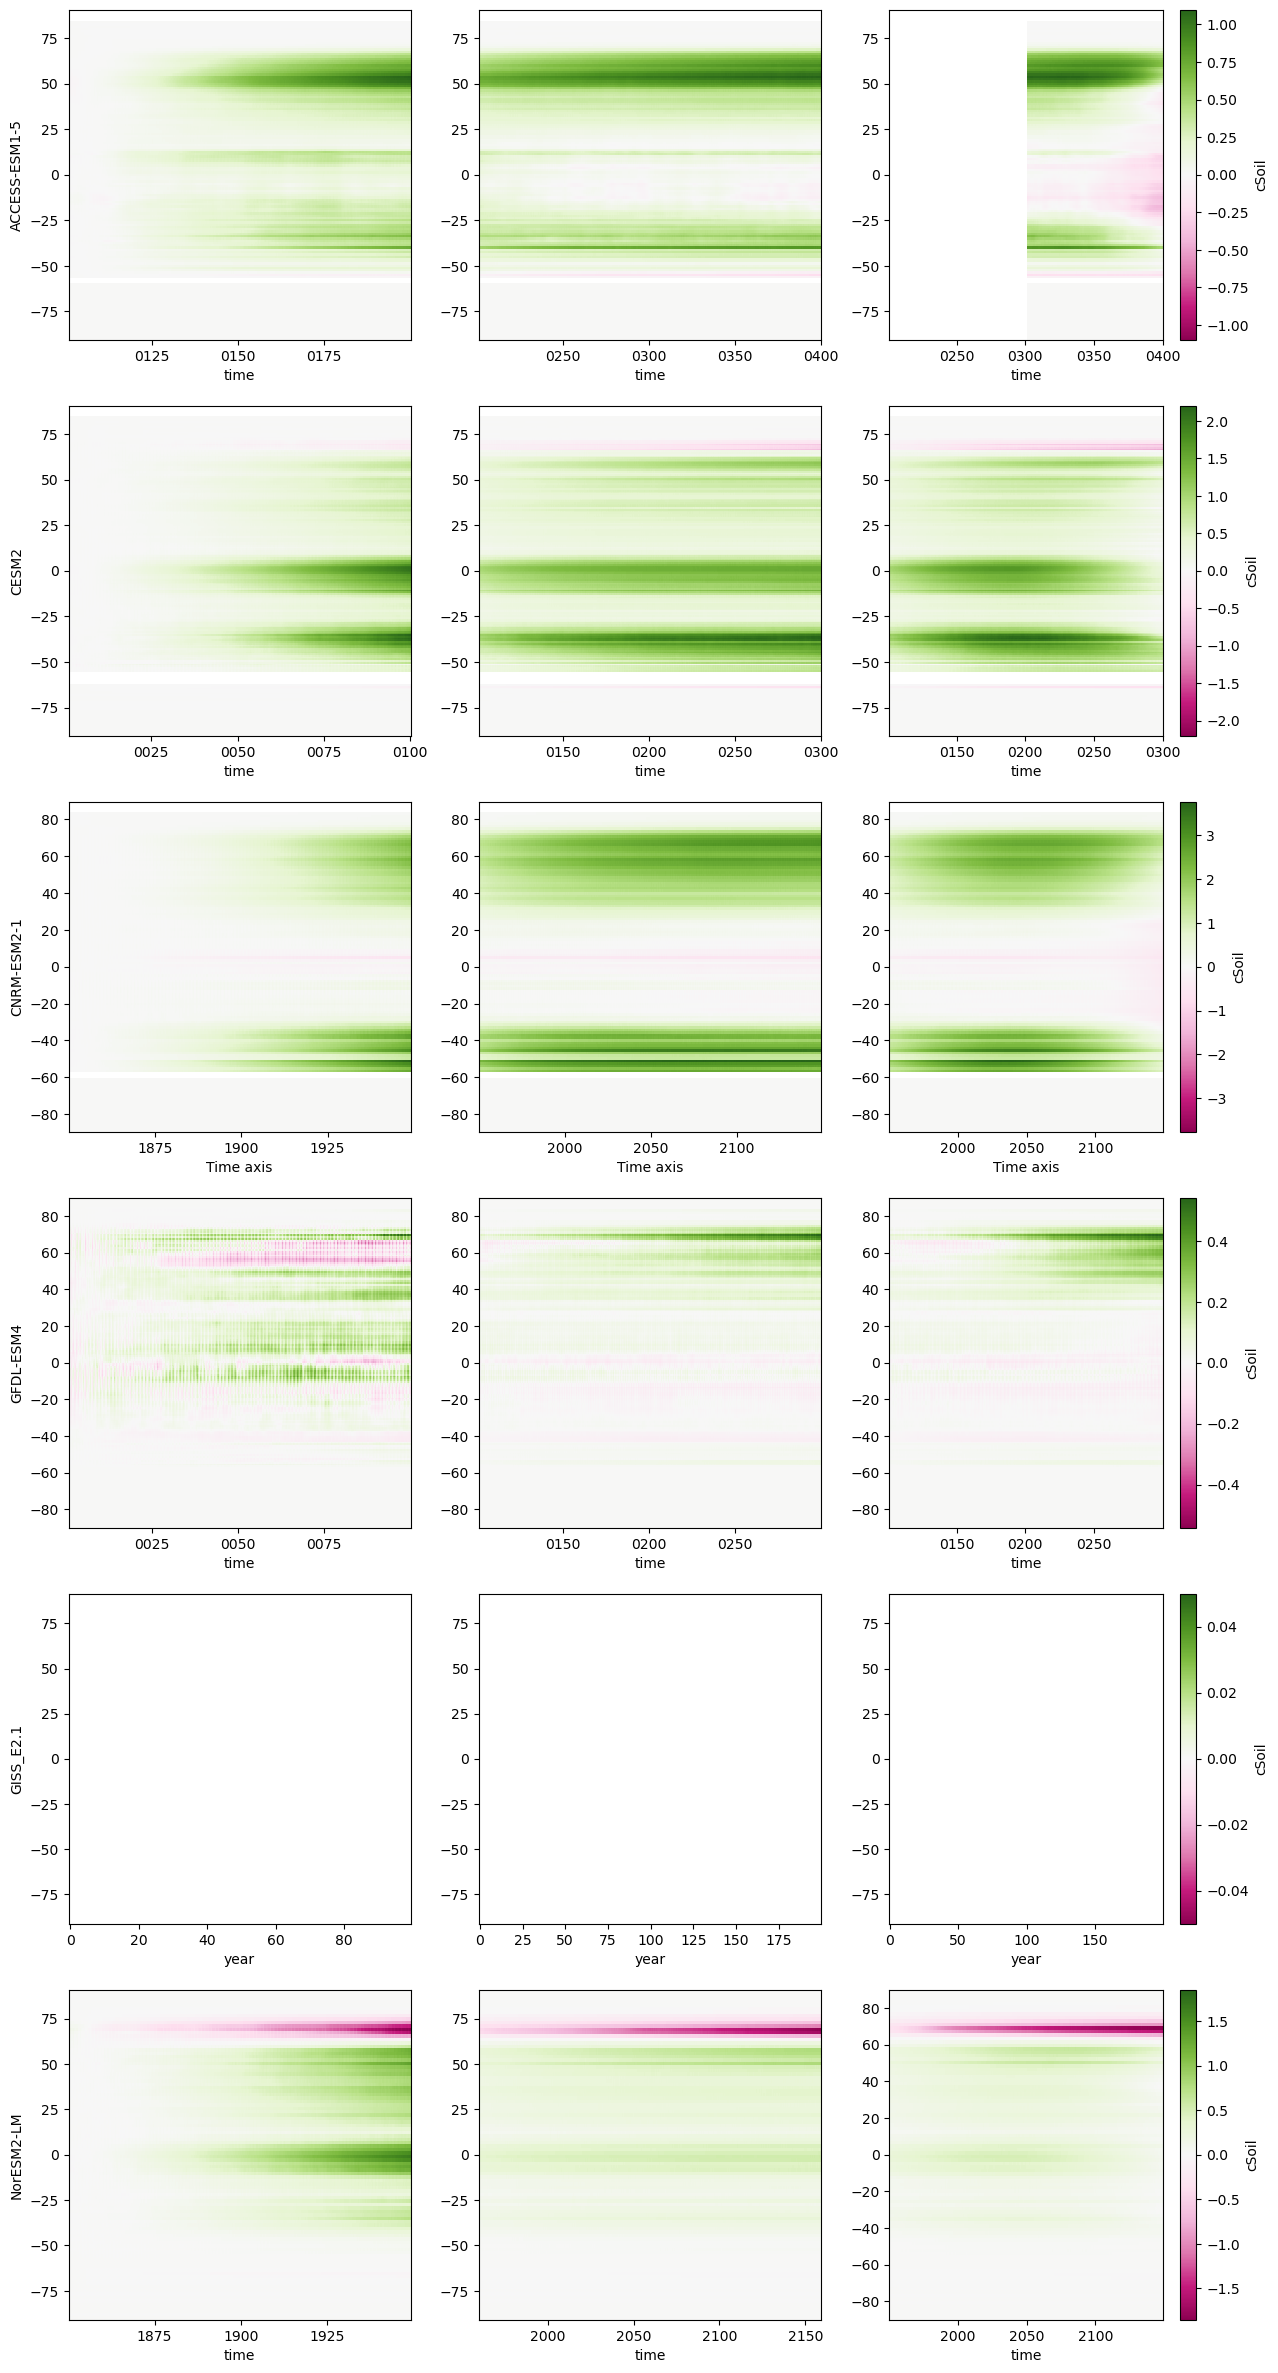

done saving file


In [31]:
plot_zonal_delta_allexp_one_var('cSoil', modellist)

Plotting ACCESS-ESM1-5
Plotting CESM2
Plotting CNRM-ESM2-1
Plotting GFDL-ESM4
Plotting GISS_E2.1
Plotting NorESM2-LM


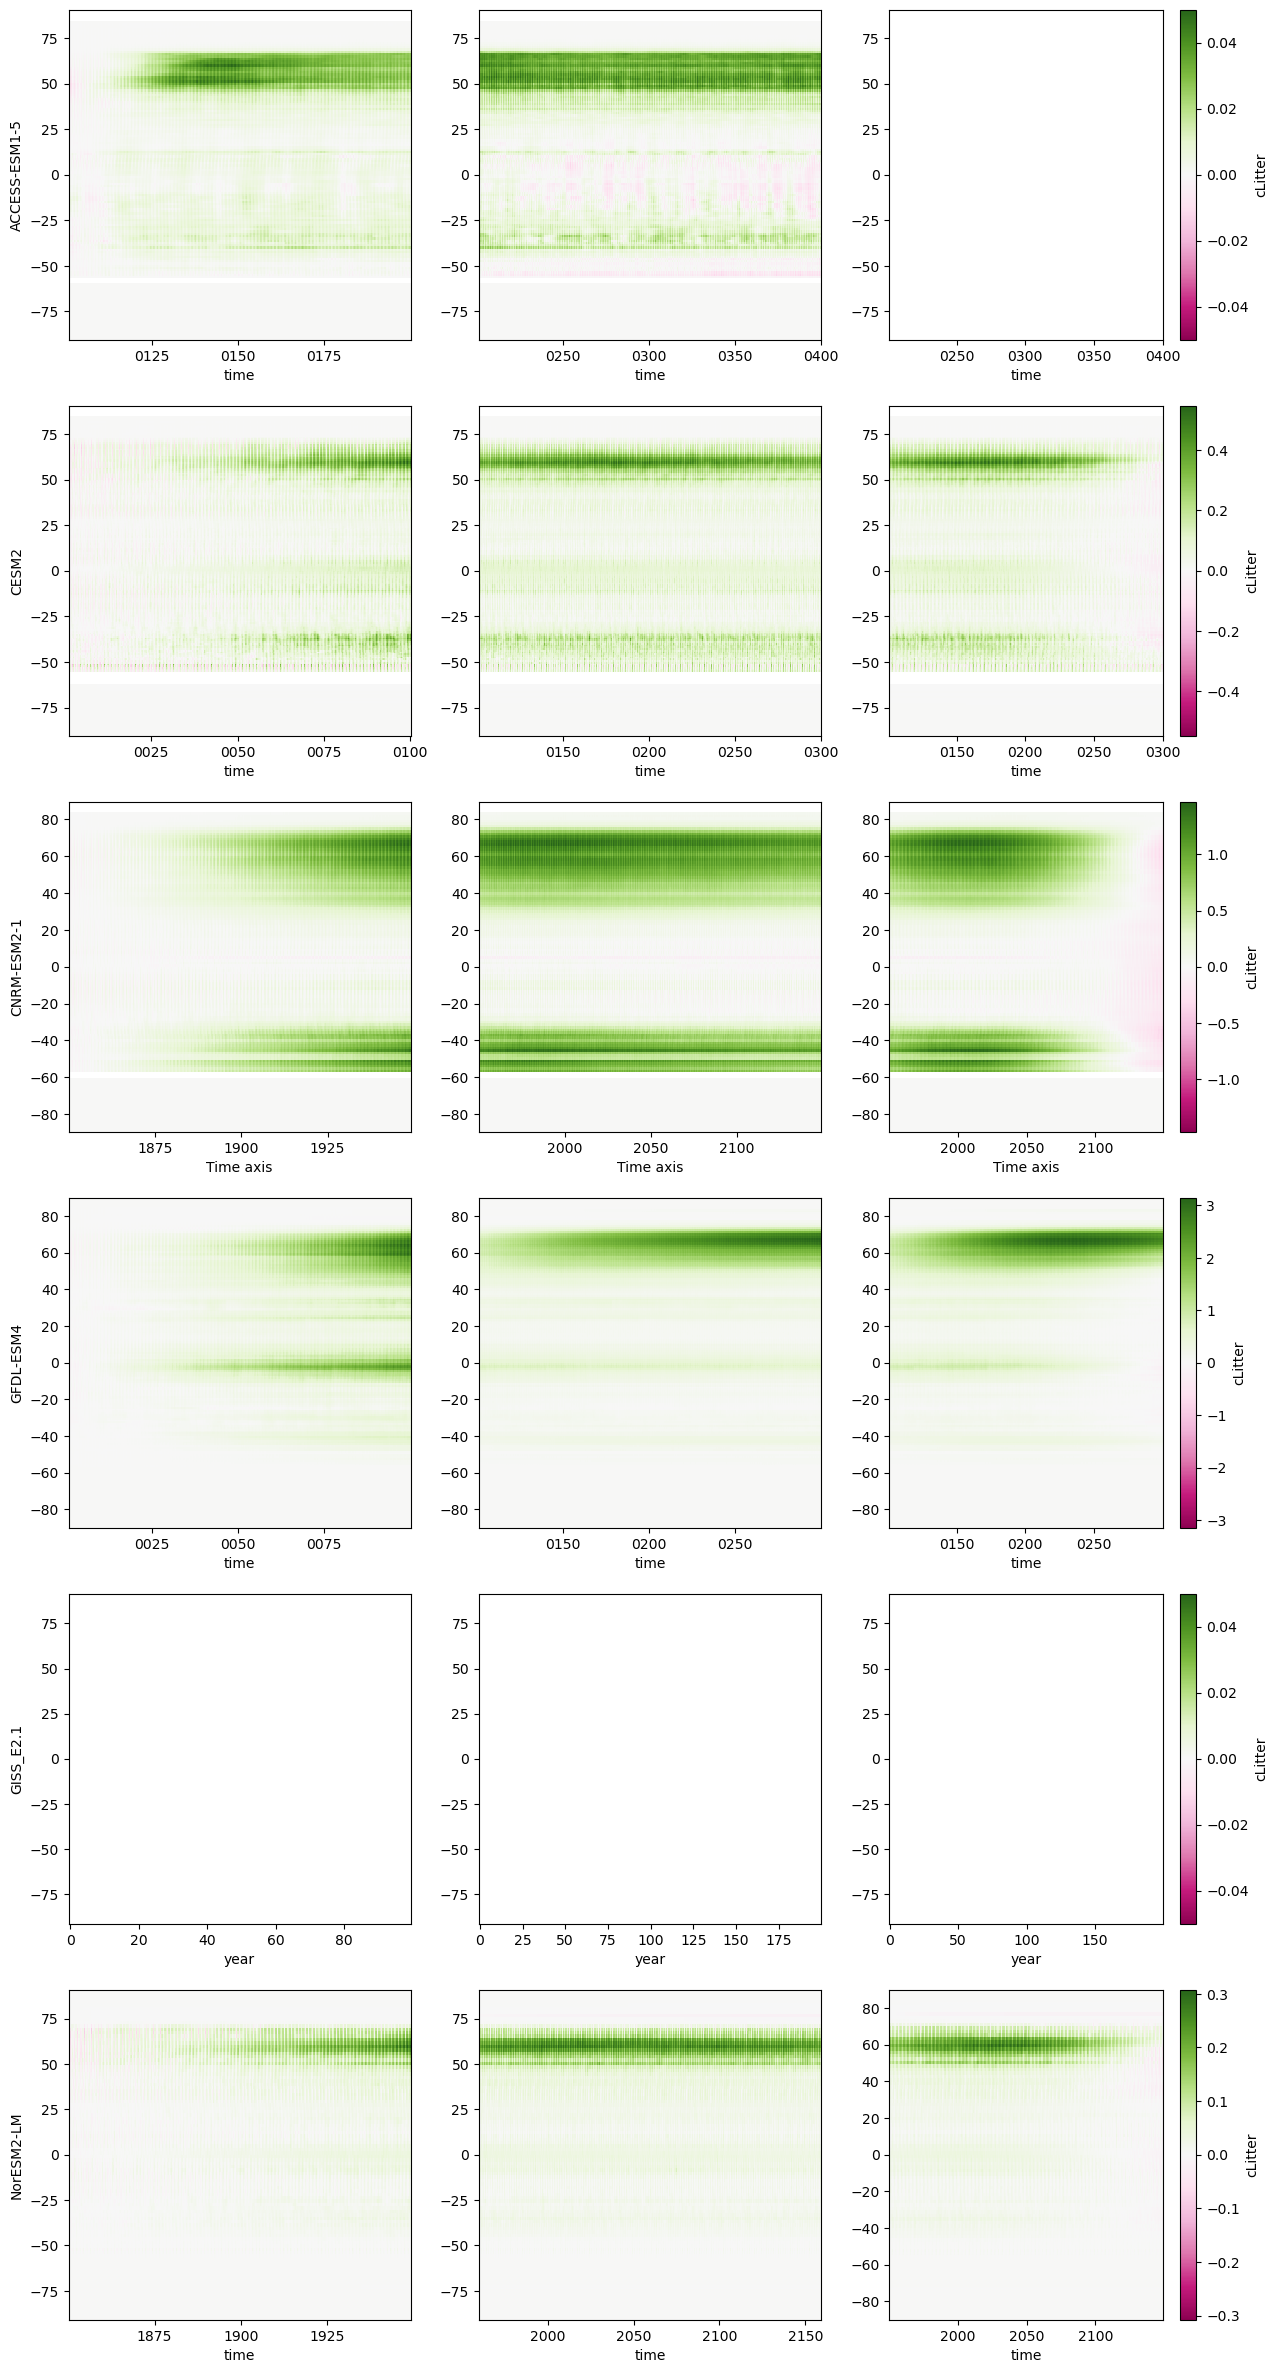

done saving file


In [32]:
plot_zonal_delta_allexp_one_var('cLitter', modellist)



Plotting ACCESS-ESM1-5
Plotting CESM2
Plotting CNRM-ESM2-1
Plotting GFDL-ESM4
Plotting GISS_E2.1
Plotting NorESM2-LM


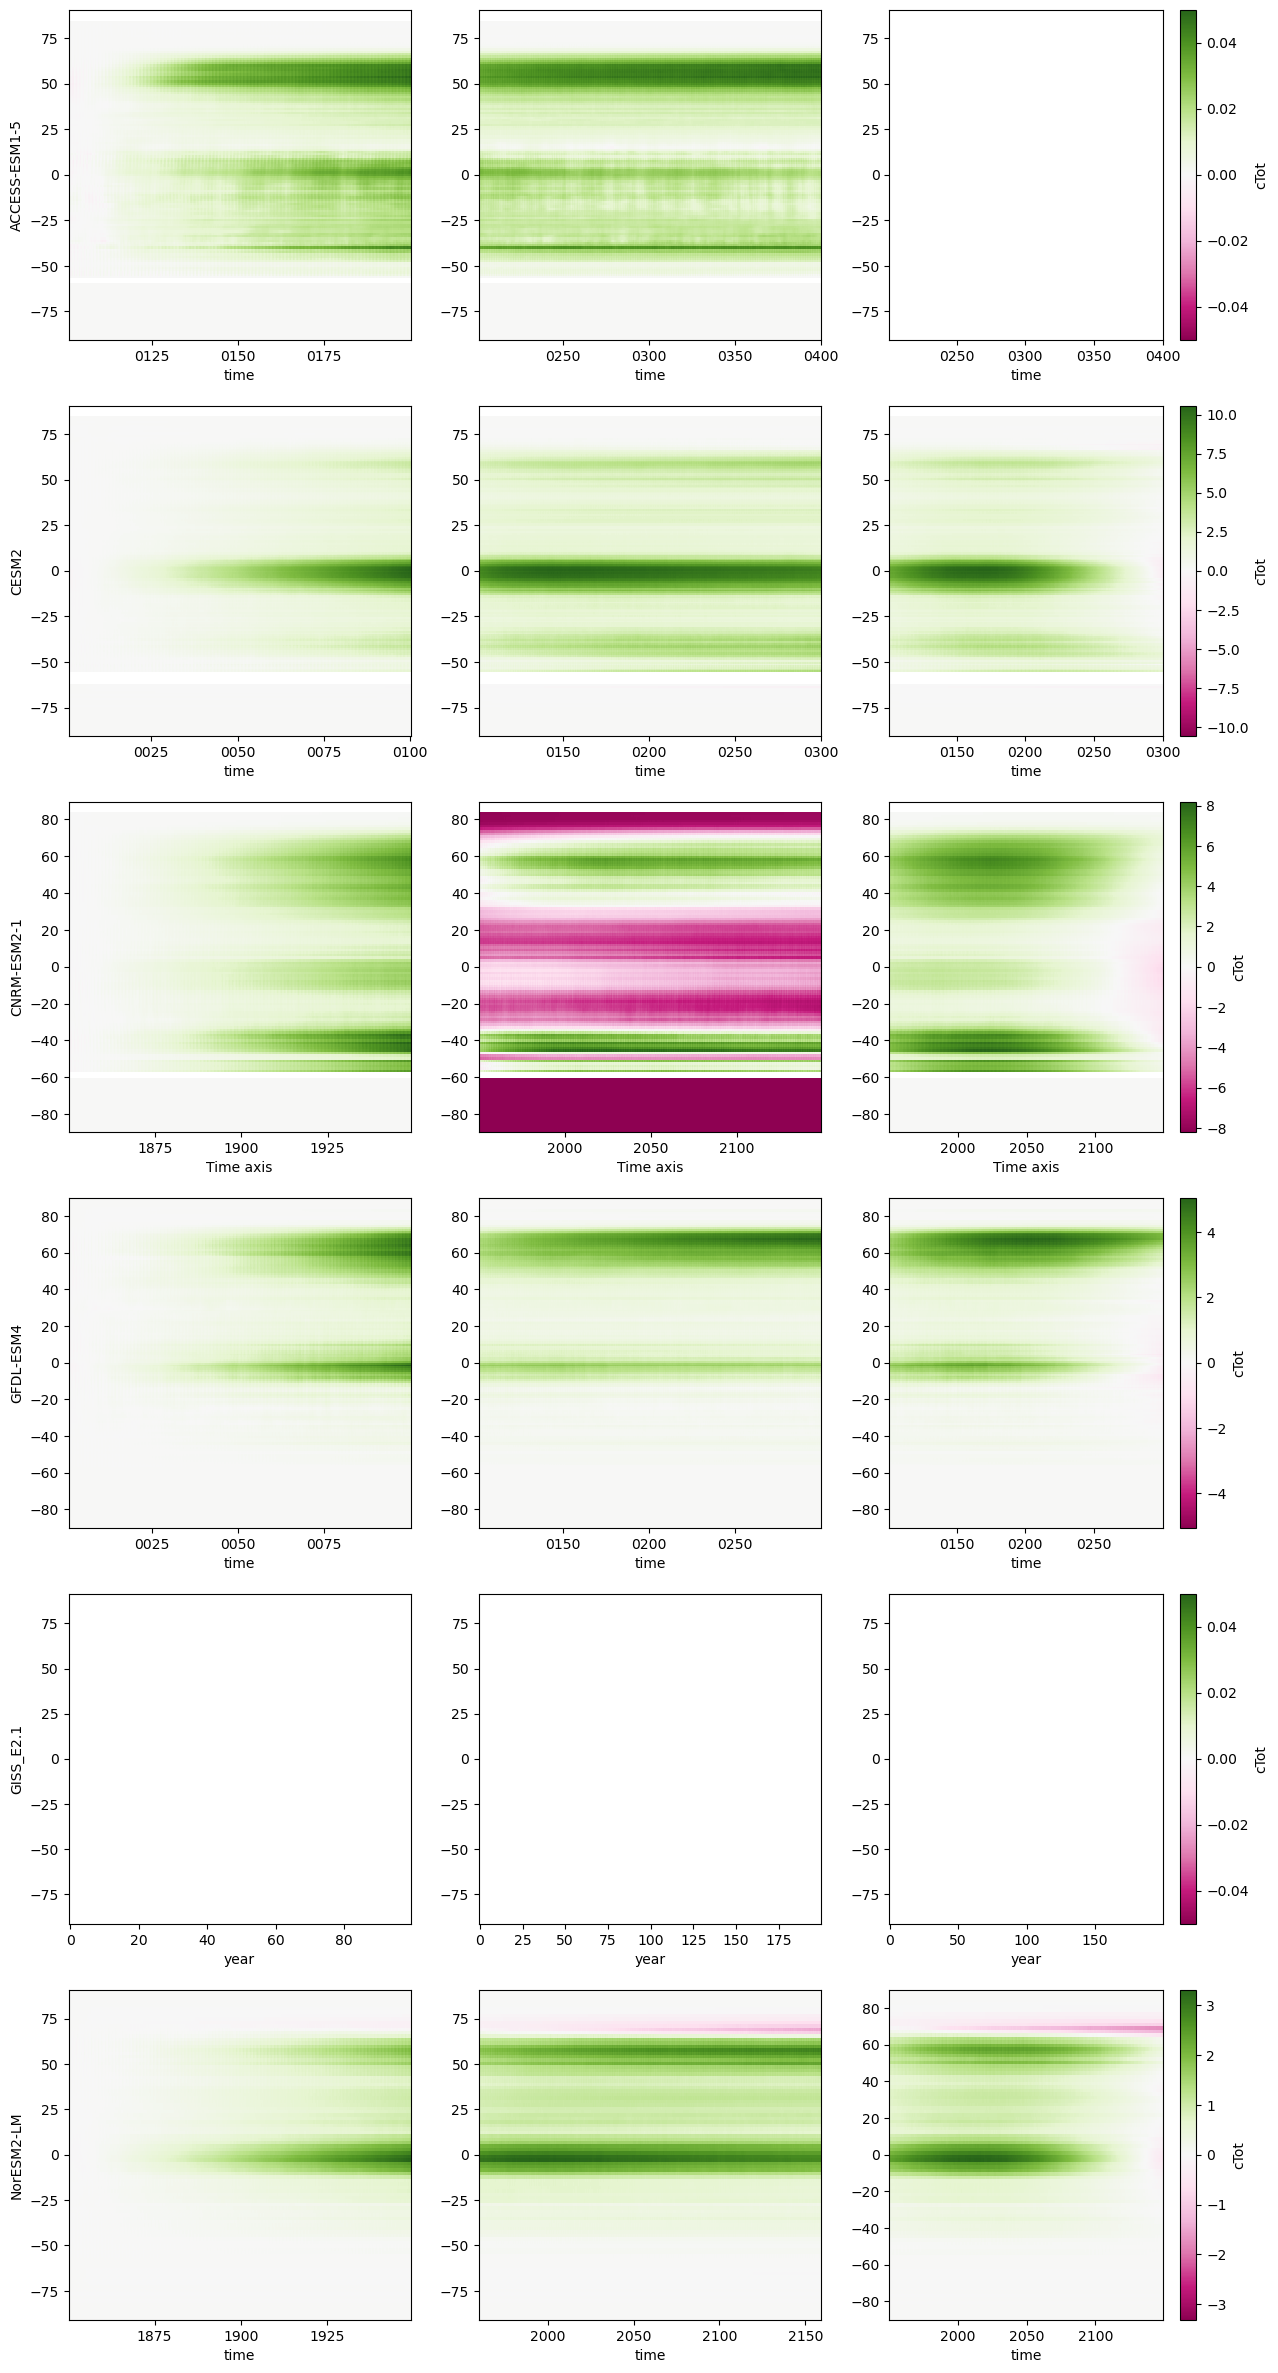

done saving file


In [33]:
plot_zonal_delta_allexp_one_var('cTot', modellist)

Plotting ACCESS-ESM1-5
Plotting CESM2
Plotting CNRM-ESM2-1
Plotting GFDL-ESM4
Plotting GISS_E2.1
Plotting NorESM2-LM


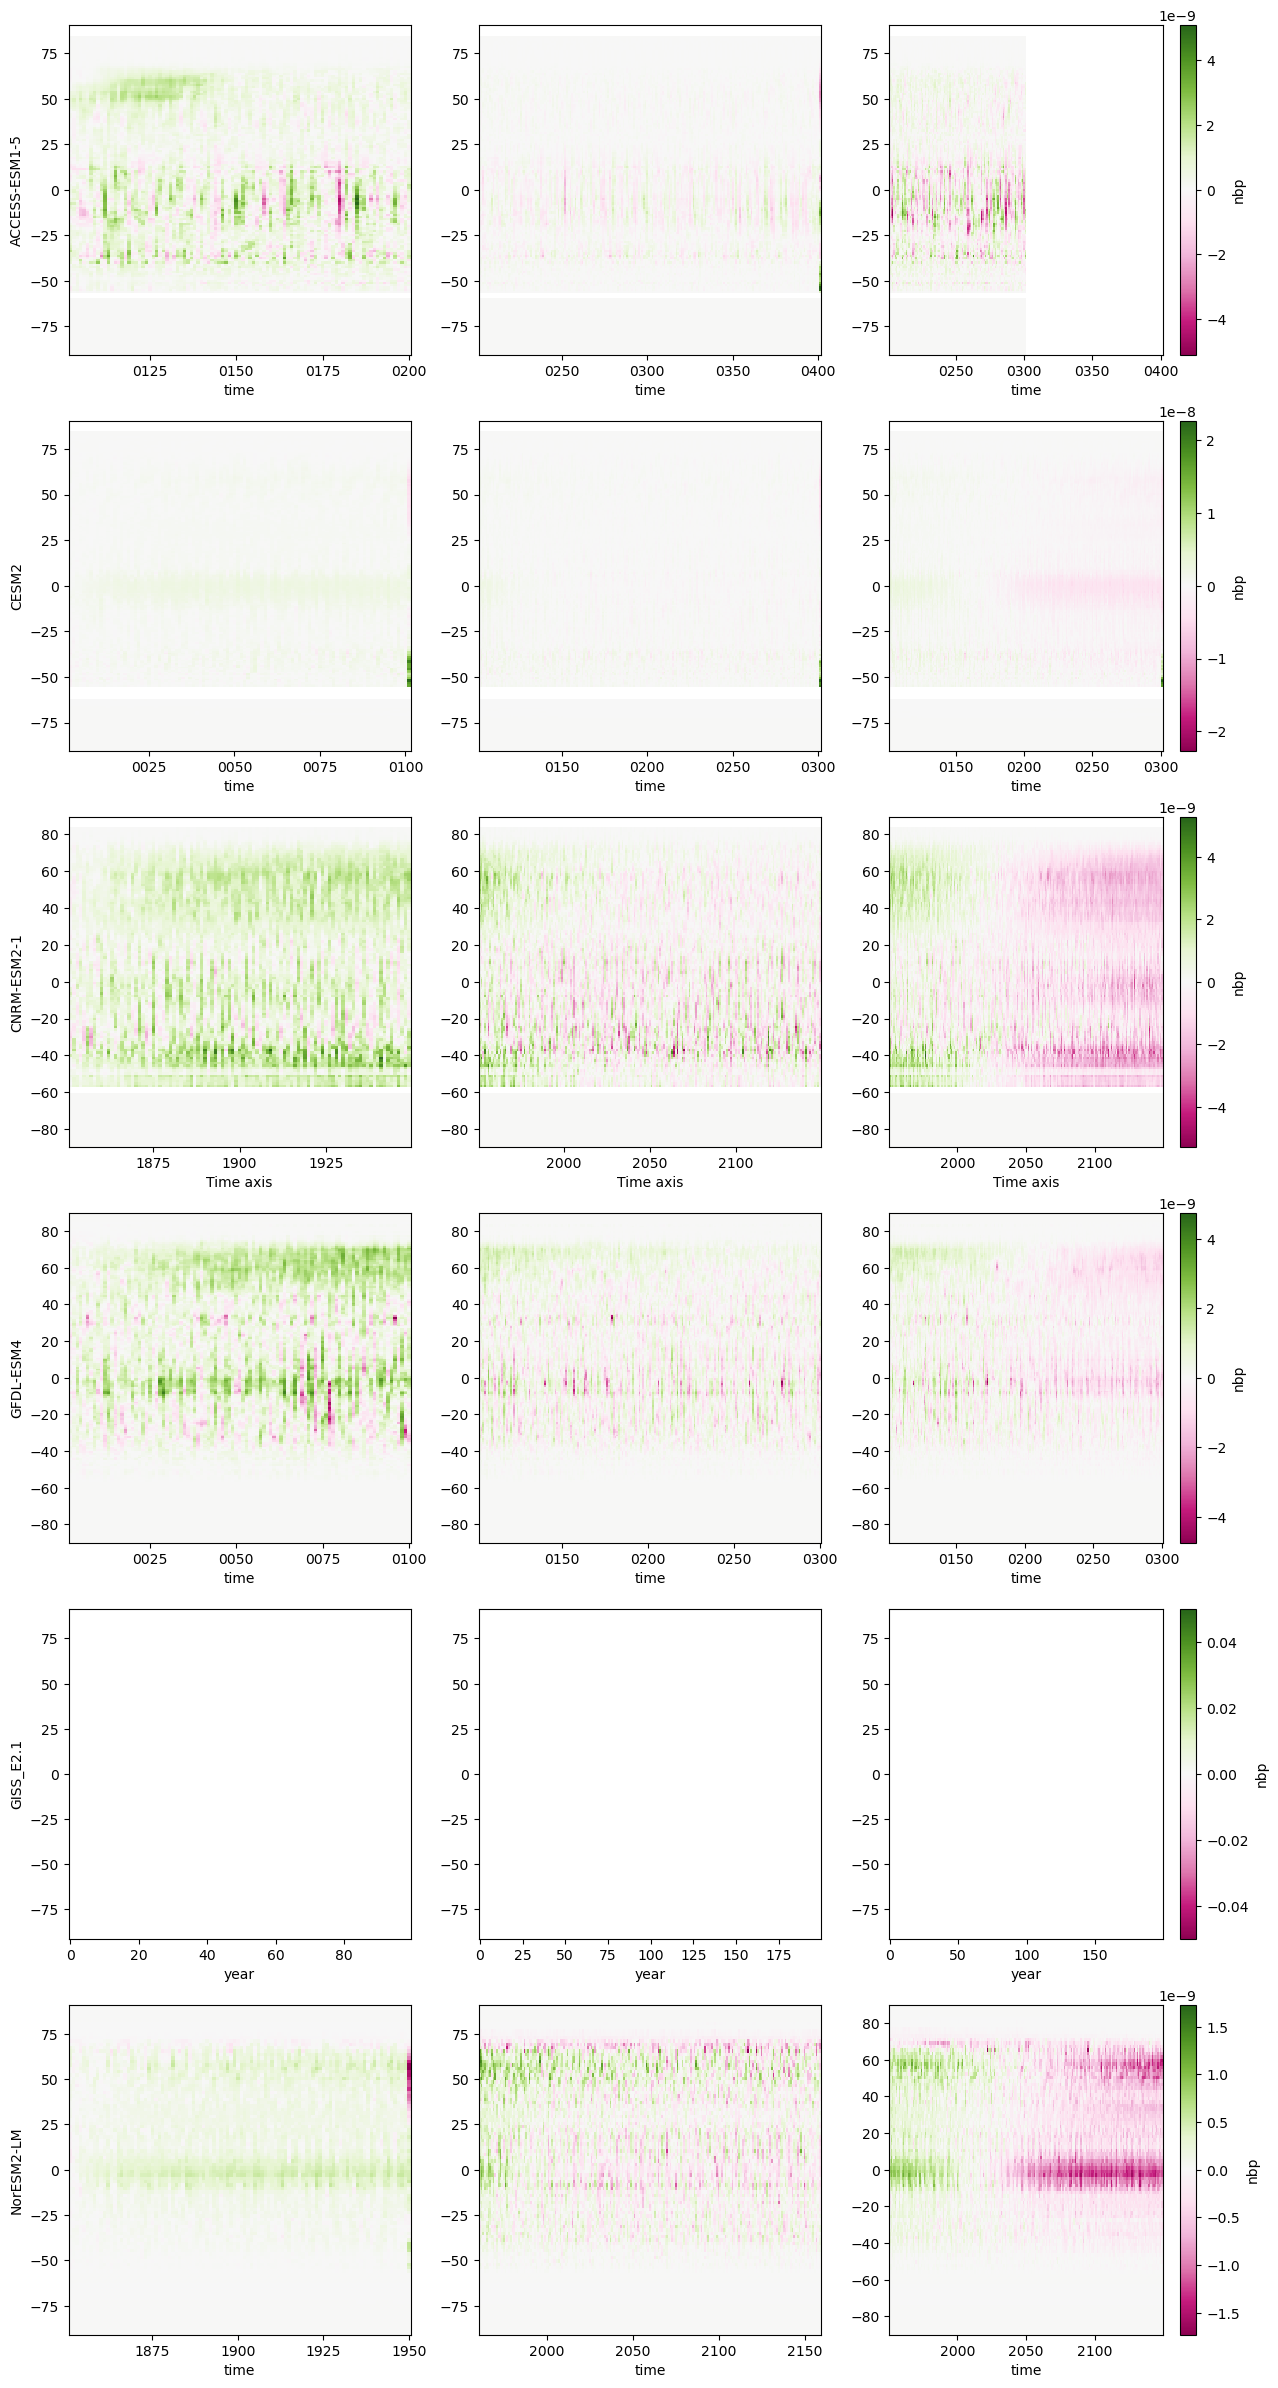

done saving file


In [34]:
plot_zonal_delta_allexp_one_var_flux('nbp', modellist)

# #---------# Snippets below #-----------#

In [46]:
ds=data_dict['CESM2_flat10']
arg=ds.resample(time='Y').mean(dim='time')
arg

<xarray.Dataset>
Dimensions:  (lon: 288, lat: 192, time: 211)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) object 0001-12-31 00:00:00 ... 0211-12-31 00:00:00
Data variables:
    cVeg     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cLitter  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cSoil    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cTot     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nbp      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/101)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Tue May 14 13:33:56 2024: ncre...
    source:                                    Community Land Model CLM4.0
    hostname:                                  derecho
    ...                                        ...
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    NCO:                                       netCDF Operators version 5.1.9...

In [108]:
st_nick =cftime.datetime(100, 2, 1,calendar='noleap', has_year_zero=True)
st_nick.calendar



<Axes: >

Plotting CNRM-ESM2-1


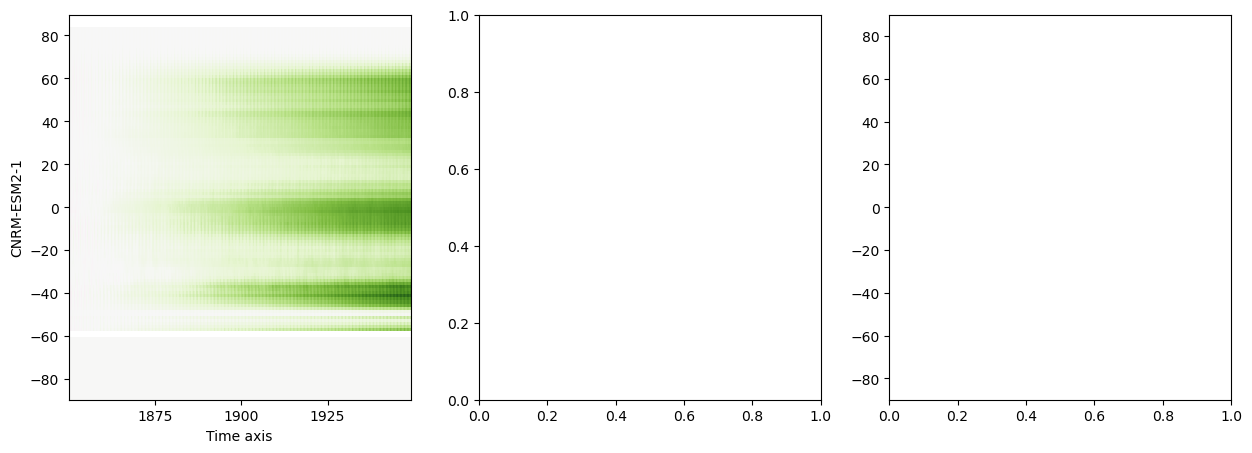

In [195]:
# zonal plots with blocks for each experiment

m=2
var='cVeg'
clim=8000

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
#fig = plt.figure(figsize=(12,2))
#fig = plt.figure(figsize=(12,12))

# --set up the subplots
# Calculate the number of rows
num_rows = 1#(len(modellist)*3 + 2) // 3  # Ceiling division to ensure we have enough rows

# Create a figure and axis objects
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axis array to iterate easily
#axs = axs.flatten()
# to use, refer to one index in axs: ax = axs[i]
    

# loop over models
##for m in range(len(modellist)):
model=modellist[m]
print('Plotting ' +model)
# create datasets for each model + experiment combination + variable
# these are already subset to the correct time blocks
ds = data_dict[modellist[m] +'_' +runlist[0]]
ds0 = select_time_slice(ds[var], 0, 99)

#find average of first 10 years
dsften = select_time_slice(ds[var], 0, 10)
if 'time' not in ds.dims:
    dsinit=dsften.mean(dim=('year','lon'))
else:
    dsinit=dsften.mean(dim=('time','lon'))

ds = data_dict[modellist[m] +'_' +runlist[1]]
ds1 = select_time_slice(ds[var], 0, 199)


ds = data_dict[modellist[m] +'_' +runlist[2]]
ds2 = select_time_slice(ds[var], 0, 199)

ax = axs[0]#[m, 0]

if 'time' not in ds.dims:
    fg = (ds0.mean(dim='lon')-dsinit).plot(x='year',cmap='PiYG',
                                           add_colorbar=False,
                                           vmax=clim,vmin=-clim,
                                           ax=ax)
else:
#    fg = (ds0-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
#                                           add_colorbar=False,
#                                           vmax=clim,vmin=-clim,
#                                           ax=ax)
    arg=(ds0.mean(dim='lon')-dsinit)
    fg = (ds0.mean(dim='lon')-dsinit).plot(x='time',cmap='PiYG',
                                           add_colorbar=False,
                                           ax=ax)

ax.set_ylabel(model)
plt.ylim([-90, 90])

if m==0:
    plt.title(runlist[0])


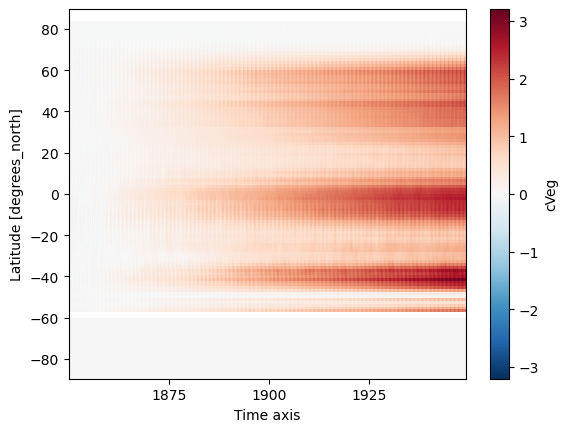

In [194]:

arg.plot(x='time')

In [ ]:
#-- now plot

#-flat10
#ax=plt.subplot(6,3,1+(m*3))

#-flat10zec
#ax=plt.subplot(6,3,1+(m*4))
ax = axs[1]#[m, 1]

if 'time' not in ds.dims:
    fg = (ds1-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG',
                                           add_colorbar=False,
                                           ax=ax)
else:
    fg = (ds1-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                           add_colorbar=False,
                                           ax=ax)

ax.set_ylabel('')
plt.ylim([-90, 90])

if m==0:
    plt.title(runlist[1])

#-flat10zec
#ax=plt.subplot(6,3,1+(m*5))
ax = axs[2]#[m, 2]

if 'time' not in ds.dims:
    fg = (ds2-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG', 
                                           ax=ax)
else:
    fg = (ds2-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                           ax=ax)

ax.set_ylabel('')
plt.ylim([-90, 90])

if m==0:
    plt.title(runlist[2])


#    fig.suptitle(model)


# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' +model +'_' +var +'_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

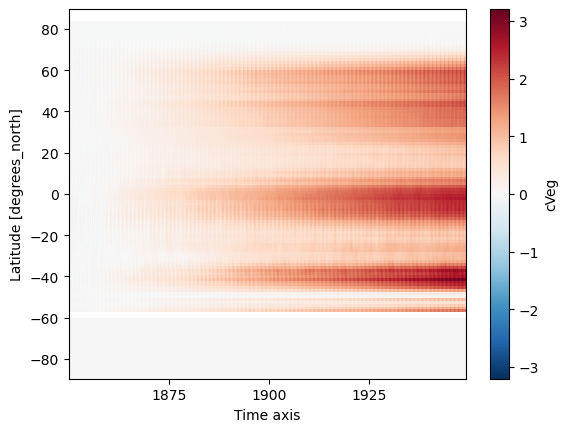

In [178]:
ds = data_dict[modellist[m] +'_' +runlist[0]]

ds0 = select_time_slice(ds[var], 0, 99)

dsdd=ds0.mean(dim='lon')
#dsdd.plot(x='time',y='lat',cmap='PiYG')
dsften = select_time_slice(ds[var], 0, 10)

#plt.pcolormesh(dsdd['time'].values, dsdd['lat'].values, dsdd[var].values[:-1,:-1]) 

#plt.pcolormesh(dsdd['time'], dsdd['lat'], dsdd.transpose('lat','time')) 
#dsdd.plot()

dsften.mean(dim='lon')
(dsdd-dsften.mean(dim=('lon','time'))).plot(x='time')
#dsften.mean(dim=('lon','time')).plot()
#dsften

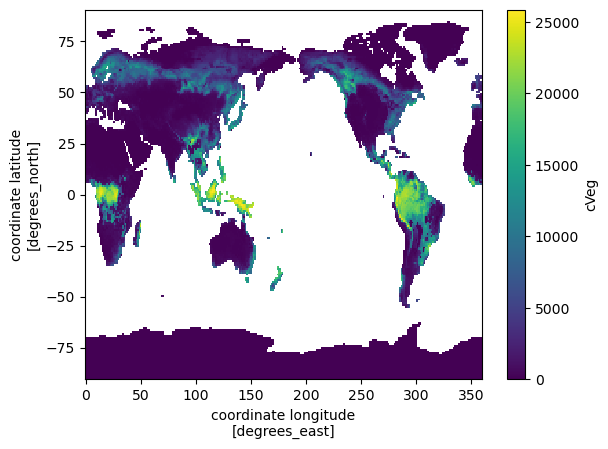

In [158]:
dsinit.plot()

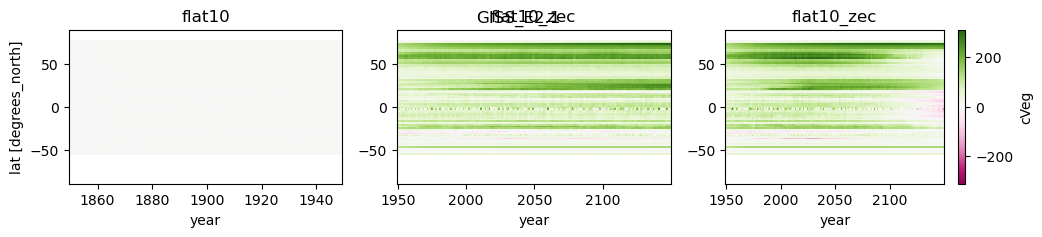

done saving file


In [84]:
# zonal plots with blocks for each experiment

m=4
var='cVeg'
clim=8000

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,2))

# loop over models
#for m in range(len(modellist)):
model=modellist[m]

# create datasets for each model + experiment combination + variable
# these are already subset to the correct time blocks
run=runlist[0]
ds = data_dict[modellist[m] +'_' +runlist[0]]
ds0 = select_time_slice(ds[var], 0, 99)

#find average of first 10 years
dsften = select_time_slice(ds[var], 0, 10)
if 'time' not in ds.dims:
    dsinit=dsften.mean(dim='year')
else:
    dsinit=dsften.mean(dim='time')

run=runlist[1]
ds = data_dict[modellist[m] +'_' +runlist[1]]
ds1 = select_time_slice(ds[var], 0, 199)


run=runlist[2]
ds = data_dict[modellist[m] +'_' +runlist[2]]
ds2 = select_time_slice(ds[var], 0, 199)


#-- now plot

#-flat10
ax=plt.subplot(1,3,1)

if 'time' not in ds.dims:
    fg = (ds0-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG',add_colorbar=False,vmax=clim,vmin=-clim)
else:
    fg = (ds0-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False,vmax=clim,vmin=-clim)
plt.ylim([-90, 90])

plt.title(runlist[0])

#-flat10zec
ax=plt.subplot(1,3,2)

if 'time' not in ds.dims:
    fg = (ds1-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG',add_colorbar=False)
else:
    fg = (ds1-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False)

plt.gca().set_ylabel('')
plt.ylim([-90, 90])

plt.title(runlist[1])

#-flat10zec
ax=plt.subplot(1,3,3)

if 'time' not in ds.dims:
    fg = (ds2-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG')
else:
    fg = (ds2-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG')

plt.gca().set_ylabel('')
plt.ylim([-90, 90])

plt.title(runlist[1])


fig.suptitle(model)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' +model +'_' +var +'_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

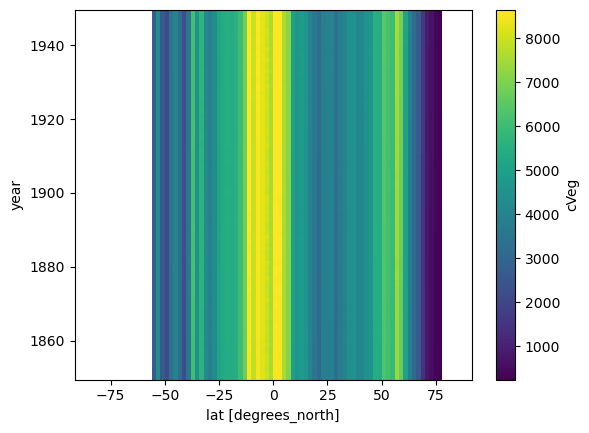

In [ ]:
# make the plot using arrays and cartopy

mapdata=(CESM2_flat10.cVeg[-23:-1,:,:].mean(dim='time')-CESM2_flat10.cVeg[0:23,:,:].mean(dim='time')).values

lat = CESM2_flat10['lat'].values
lon = CESM2_flat10['lon'].values

ax = plt.axes(projection=ccrs.Robinson())
#        ax.set_extent([-140, -75, 15, 75], ccrs.PlateCarree())
ax.coastlines()

#-- Make the actual Plot
cs = plt.pcolormesh(lon,lat,mapdata, transform=ccrs.PlateCarree())#PlateCarree())#Robinson())#
plt.set_cmap(cmap='PiYG')

# set color limits
plt.clim([-20000, 20000]) 

# add a colorbar:
# make an axes for the colorbar
#cax = plt.axes([left, bottom, width, height])
cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')
cbar = plt.colorbar(cax=cax,orientation='horizontal',extend='both')#,pad=.02, shrink=0.9) #use cax here, which means getting rid of pad
cbar.ax.tick_params(labelsize=14) 



In [104]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +' = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

ACCESS_flat10 = dsmerge_v.copy(deep=True)
ACCESS_flat10_zec = dsmerge_v.copy(deep=True)
ACCESS_flat10_cdr = dsmerge_v.copy(deep=True)
CESM2_flat10 = dsmerge_v.copy(deep=True)
CESM2_flat10_zec = dsmerge_v.copy(deep=True)
CESM2_flat10_cdr = dsmerge_v.copy(deep=True)
CNRM_flat10 = dsmerge_v.copy(deep=True)
CNRM_flat10_zec = dsmerge_v.copy(deep=True)
CNRM_flat10_cdr = dsmerge_v.copy(deep=True)
GFDL_flat10 = dsmerge_v.copy(deep=True)
GFDL_flat10_zec = dsmerge_v.copy(deep=True)
GFDL_flat10_cdr = dsmerge_v.copy(deep=True)
GISS_flat10 = dsmerge_v.copy(deep=True)
GISS_flat10_zec = dsmerge_v.copy(deep=True)
GISS_flat10_cdr = dsmerge_v.copy(deep=True)
NorESM2_flat10 = dsmerge_v.copy(deep=True)
NorESM2_flat10_zec = dsmerge_v.copy(deep=True)
NorESM2_flat10_cdr = dsmerge_v.copy(deep=True)


In [255]:
def plot_all_models_one_deltavar(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,14))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print(model)    
        # create datasets for each model + experiment combination + variable
        exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
        print(exestr)
        exec(exestr, globals())
        #ds = model_run.var
        
        ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())

        if model == 'GISS_E2.1':
            arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
        else:
            arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))
    
        fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
    
        fg.axes.coastlines()
        plt.title(model)
    
    # add a title over the whole figure with the name of the run
    fig.suptitle(run)
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [ ]:
def plot_all_models_zonal_by_time(var, run, modellist, modellist_safe):
    # zonal plots
    
   
    #def plot_all_models_one_var(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,12))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
    
        # create datasets for each model + experiment combination + variable
        exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
        print(exestr)
        exec(exestr, globals())
        #ds = model_run.var
        
        ax=plt.subplot(3,2,m+1)
    
        if model == 'GISS_E2.1':
            arg=(ds.mean(dim='lon'))
        else:
            arg=(ds.mean(dim='lon'))
    
        fg = arg.plot(x='lat',cmap='YlGn')
        plt.xlim([-90, 90])
        
        plt.title(model)
    
    fig.suptitle(run)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [ ]:
def plot_all_models_zonal_by_time(var, run, modellist, modellist_safe):
    # zonal plots
    
   
    #def plot_all_models_one_var(var, run, modellist, modellist_safe):
    fig = plt.figure(figsize=(12,12))
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
    
        # create datasets for each model + experiment combination + variable
        exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
        print(exestr)
        exec(exestr, globals())
        #ds = model_run.var
        
        ax=plt.subplot(3,2,m+1)
    
        if model == 'GISS_E2.1':
            arg=(ds.mean(dim='lon'))
        else:
            arg=(ds.mean(dim='lon'))
    
        fg = arg.plot(x='lat',cmap='YlGn')
        plt.xlim([-90, 90])
        
        plt.title(model)
    
    fig.suptitle(run)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

ds=ACCESS_flat10.cVeg
ds=CESM2_flat10.cVeg
ds=CNRM_flat10.cVeg
ds=GFDL_flat10.cVeg
ds=GISS_flat10.cVeg
ds=NorESM2_flat10.cVeg


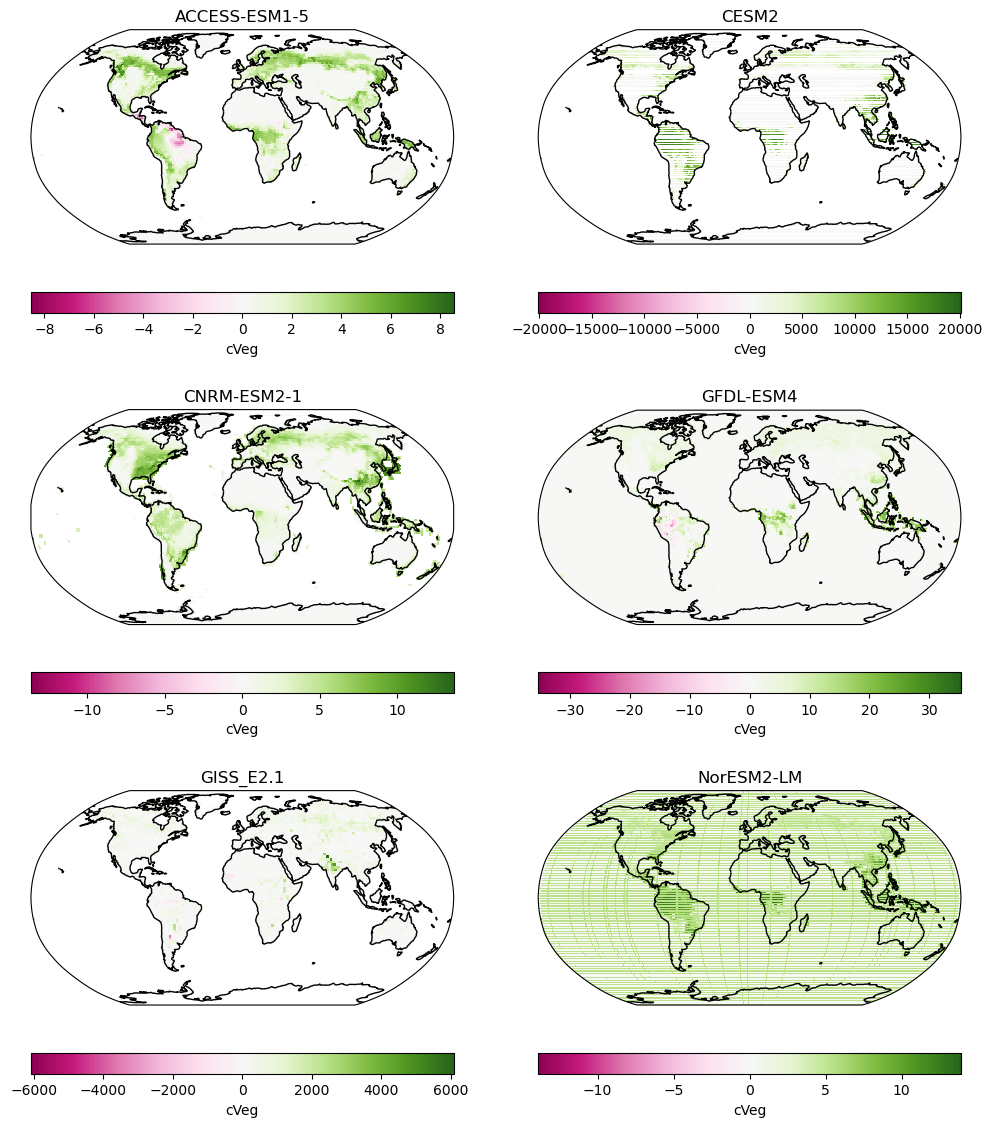

done saving file


In [65]:
run=runlist[0]
var='cVeg'

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,14))

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # create datasets for each model + experiment combination + variable
    exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr)
    #ds = model_run.var
    
    ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())

    if model == 'GISS_E2.1':
        arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
    else:
        arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))

    fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')

    fg.axes.coastlines()
    plt.title(model)


# show the plot:
plt.show()

# save the plot
fig.savefig('figures/' +run +'_' +var +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

In [222]:
# zonal plots

def plot_zonal_allexp(var, m, modellist, modellist_safe,timename,clim):
    fig = plt.figure(figsize=(12,3))
    
    # loop over models
    #for m in range(len(modellist)):
    
    
    # create datasets for each model + experiment combination + variable
    run=runlist[0]
    exestr= 'ds0=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr, globals())
    #ds = model_run.var
    
    dsinit=ds0.sel(time=slice(cftime.DatetimeNoLeap(1+startyear-1, 2, 1,has_year_zero=True),
                              cftime.DatetimeNoLeap(3+startyear-1, 2, 1,has_year_zero=True))).mean(dim='time')
    
    run=runlist[1]
    exestr= 'ds1=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr, globals())
    #ds = model_run.var
    
    run=runlist[2]
    exestr= 'ds2=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr, globals())
    #ds = model_run.var
    
    #-- now plot
    
    #-flat10 first
    #ax=plt.subplot(1,4,1)
    #st=cftime.DatetimeNoLeap(1, 2, 1,has_year_zero=True)
    #et=cftime.DatetimeNoLeap(3, 1, 1,has_year_zero=True)
    
    #fg = (ds0.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='YlGn',add_colorbar=True)
    #plt.ylim([-90, 90])
    
    ax=plt.subplot(1,3,1)
    #arr0=ds0.mean(dim='lon')
    
    st=cftime.DatetimeNoLeap(1+startyear-1, 2, 1,has_year_zero=True)
    et=cftime.DatetimeNoLeap(100+startyear-1, 1, 1,has_year_zero=True)
    
    fg = (ds0.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False,vmax=clim,vmin=-clim)
    plt.ylim([-90, 90])
    
    plt.title(runlist[0])
    
    #-flat10zec
    ax=plt.subplot(1,3,2)
    
    #arr0=ds0.mean(dim='lon')
    
    st=cftime.DatetimeNoLeap(100+startyear-1, 2, 1,has_year_zero=True)
    et=cftime.DatetimeNoLeap(300+startyear-1, 1, 1,has_year_zero=True)
    
    fg = (ds1.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',add_colorbar=False)
    plt.ylim([-90, 90])
    
    plt.title(runlist[1])
    
    #-flat10zec
    ax=plt.subplot(1,3,3)
    
    #arr0=ds0.mean(dim='lon')
    
    st=cftime.DatetimeNoLeap(100+startyear-1, 2, 1,has_year_zero=True)
    et=cftime.DatetimeNoLeap(300+startyear-1, 1, 1,has_year_zero=True)
    
    fg = (ds2.sel(time=slice(st,et))-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG')
    plt.ylim([-90, 90])
    
    plt.title(runlist[1])
    
    
    fig.suptitle(model)
    # show the plot:
    plt.show()
    
    
    # save the plot
    fig.savefig('figures/' +model +'_' +var +'_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

In [223]:

cftimetype = [
    'DatetimeNoLeap'
    'DatetimeGregorian'


m=2
var='cVeg'
clim=8000
startyear=1850
plot_zonal_allexp(var, m, modellist, modellist_safe,startyear,clim)

ds0=CNRM_flat10.cVeg


TypeError: cannot compare cftime.DatetimeGregorian(1920, 7, 16, 12, 0, 0, 0, has_year_zero=False) and cftime.DatetimeNoLeap(1850, 2, 1, 0, 0, 0, 0, has_year_zero=True)

<Figure size 1200x300 with 0 Axes>

In [ ]:
# zonal plots with blocks for each experiment

#m=4
var='cVeg'
clim=8000

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
#fig = plt.figure(figsize=(12,2))
#fig = plt.figure(figsize=(12,12))

# --set up the subplots
# Calculate the number of rows
num_rows = (len(modellist)*3 + 2) // 3  # Ceiling division to ensure we have enough rows

# Create a figure and axis objects
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axis array to iterate easily
#axs = axs.flatten()
# to use, refer to one index in axs: ax = axs[i]
    

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)
    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    run=runlist[0]
    ds = data_dict[modellist[m] +'_' +runlist[0]]
    ds0 = select_time_slice(ds[var], 0, 99)
    
    #find average of first 10 years
    dsften = select_time_slice(ds[var], 0, 10)
    if 'time' not in ds.dims:
        dsinit=dsften.mean(dim='year')
    else:
        dsinit=dsften.mean(dim='time')
    
    run=runlist[1]
    ds = data_dict[modellist[m] +'_' +runlist[1]]
    ds1 = select_time_slice(ds[var], 0, 199)
    
    
    run=runlist[2]
    ds = data_dict[modellist[m] +'_' +runlist[2]]
    ds2 = select_time_slice(ds[var], 0, 199)
    
    
    #-- now plot
    
    #-flat10
    #ax=plt.subplot(6,3,1+(m*3))
    ax = axs[m, 0]
    
    if 'time' not in ds.dims:
        fg = (ds0-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG',
                                               add_colorbar=False,
                                               vmax=clim,vmin=-clim,
                                               ax=ax)
    else:
        fg = (ds0-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                               add_colorbar=False,
                                               vmax=clim,vmin=-clim,
                                               ax=ax)
    
    ax.set_ylabel(model)
    plt.ylim([-90, 90])
    
    if m==0:
        plt.title(runlist[0])
    
    #-flat10zec
    #ax=plt.subplot(6,3,1+(m*4))
    ax = axs[m, 1]
    
    if 'time' not in ds.dims:
        fg = (ds1-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG',
                                               add_colorbar=False,
                                               ax=ax)
    else:
        fg = (ds1-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                               add_colorbar=False,
                                               ax=ax)
    
    ax.set_ylabel('')
    plt.ylim([-90, 90])

    if m==0:
        plt.title(runlist[1])
    
    #-flat10zec
    #ax=plt.subplot(6,3,1+(m*5))
    ax = axs[m, 2]
    
    if 'time' not in ds.dims:
        fg = (ds2-dsinit).mean(dim='lon').plot(x='year',cmap='PiYG', 
                                               ax=ax)
    else:
        fg = (ds2-dsinit).mean(dim='lon').plot(x='time',cmap='PiYG',
                                               ax=ax)
    
    ax.set_ylabel('')
    plt.ylim([-90, 90])

    if m==0:
        plt.title(runlist[2])
    
    
#    fig.suptitle(model)


# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' +model +'_' +var +'_zonal_by_time_acrossexp.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

In [225]:
modellist

DatetimeProlepticGregorian
DatetimeNoLeap
DatetimeGregorian
DatetimeNoLeap
year
DatetimeNoLeap

101
1
1850
1
1850
1850

['ACCESS-ESM1-5',
 'CESM2',
 'CNRM-ESM2-1',
 'GFDL-ESM4',
 'GISS_E2.1',
 'NorESM2-LM']

In [231]:
NorESM2_flat10

<xarray.Dataset>
Dimensions:    (time: 1799, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1850-02-15 00:00:00 ... 1999-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1850-02-01 00:00:00 ... 2000-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.05 -89.05 ... 89.05 90.0
    lon_bnds   (time, lon, bnds) float64 -1.25 1.25 1.25 ... 356.2 356.2 358.7
    cVeg       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cLitter    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cSoil      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1851-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               cVeg
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/0cb7c5f5-4b67-43dd-8f6f-c9376572aadb

In [ ]:
# zonal plots

run=runlist[0]
var='cVeg'

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # create datasets for each model + experiment combination + variable
    exestr= 'ds=' +modellist_safe[m] +'_' +run +'.' +var
    print(exestr)
    exec(exestr)
    #ds = model_run.var
    
    ax=plt.subplot(3,2,m+1)

    if model == 'GISS_E2.1':
        #arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year')).mean(dim='lon')
        arg=(ds.mean(dim='lon'))
    else:
        #arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time')).mean(dim='lon')
        arg=(ds.mean(dim='lon'))

    fg = arg.plot(x='lat',cmap='YlGn')
    plt.xlim([-90, 90])
    
    plt.title(model)

fig.suptitle(run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' +run +'_' +var +'_zonal_by_time.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

ds=ACCESS_flat10_zec.cVeg
ds=CESM2_flat10_zec.cVeg
ds=CNRM_flat10_zec.cVeg
ds=GFDL_flat10_zec.cVeg
ds=GISS_flat10_zec.cVeg
ds=NorESM2_flat10_zec.cVeg


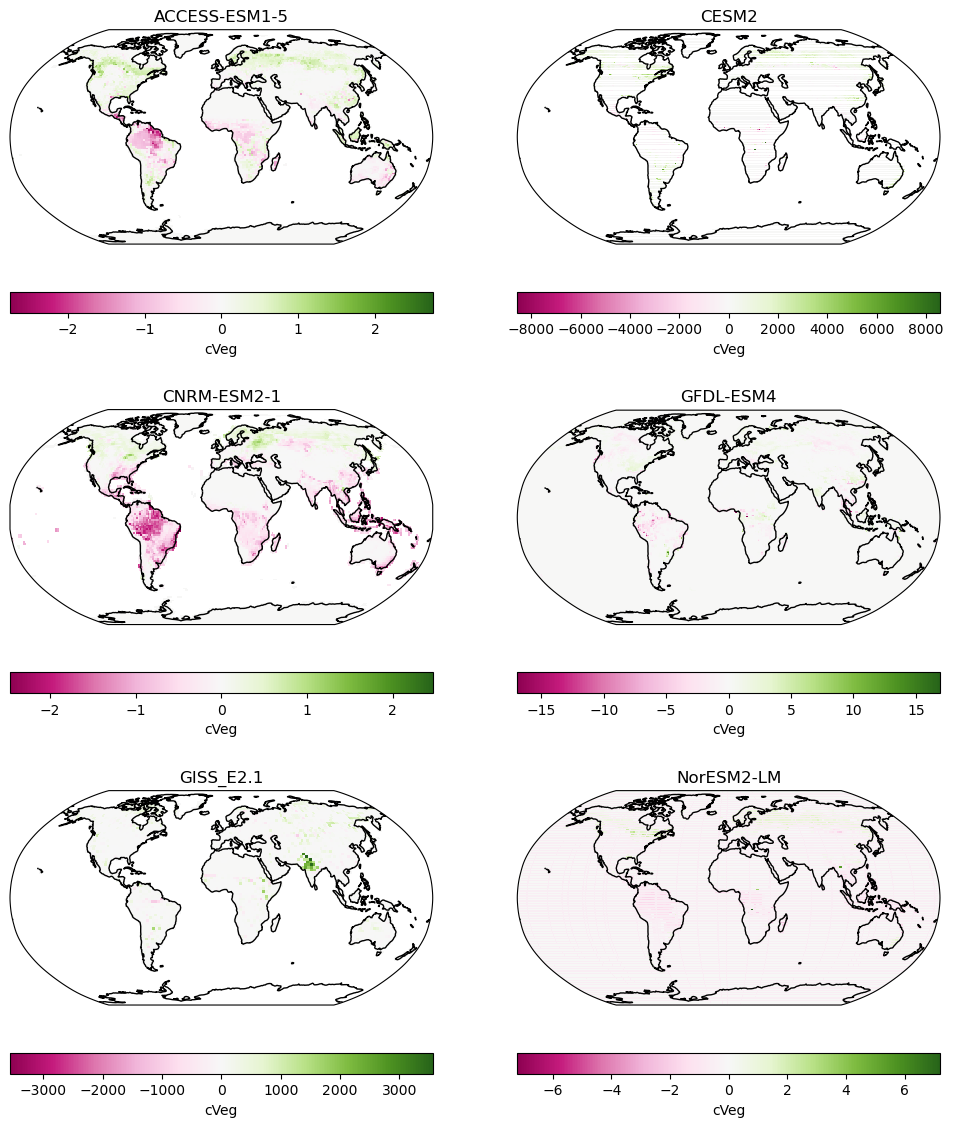

done saving file


In [66]:
#building the function

r=1
var='cVeg'

fig = plt.figure(figsize=(12,14))

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # create datasets for each model + experiment combination + variable
    exestr= 'ds=' +modellist_safe[m] +'_' +runlist[r] +'.' +var
    print(exestr)
    exec(exestr)
    #ds = model_run.cVeg
    
    #ax = plt.subplot(9,4,i+1,projection=ccrs.Robinson())
    ax=plt.subplot(3,2,m+1,projection=ccrs.Robinson())
    #ds_delta[var][:,:,i].plot()#vmin=-2, vmax=2, cmap=)
    if model == 'GISS_E2.1':
        arg=(ds[-2:-1,:,:].mean(dim='year')-ds[0:2,:,:].mean(dim='year'))
    else:
        arg=(ds[-23:-1,:,:].mean(dim='time')-ds[0:23,:,:].mean(dim='time'))

    fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'},cmap='PiYG')
#    fg = arg.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'vertical'},cmap='PiYG')

    fg.axes.coastlines()
    plt.title(model)


# show the plot:
plt.show()

# save the plot
fig.savefig('figures/' +runlist[r] +'_' +var +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

TypeError: 'Text' object is not callable

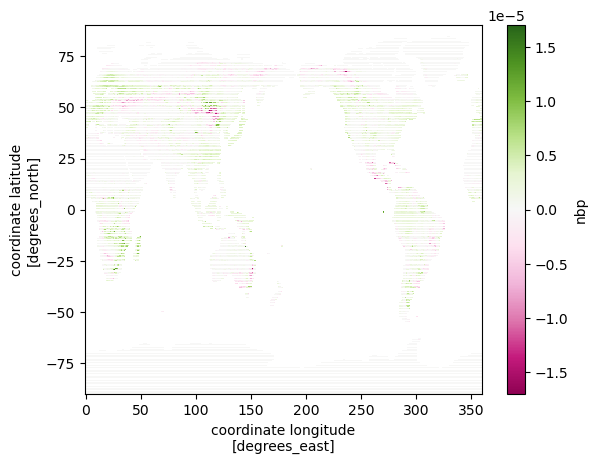

In [41]:
# difference in cVeg between end of flat10 and beginning of flat10
(CESM2_flat10.nbp[-23:-1,:,:].mean(dim='time')-CESM2_flat10.nbp[0:23,:,:].mean(dim='time')).plot(cmap='PiYG')

In [ ]:
#---------# Snippets below #-----------#

In [ ]:
for f in range(len(filenamelist)):
    file = filenamelist[f]
    if f==0:
        dsmerge_f2 = xr.open_dataset(file, use_cftime=True)
    else:
        ds = xr.open_dataset(file, use_cftime=True)
        dsmerge_f2.combine_first(ds)#],dim='time')
        #ds2=ddsmerge_f.combine_first(ds1)

dsmerge_f2

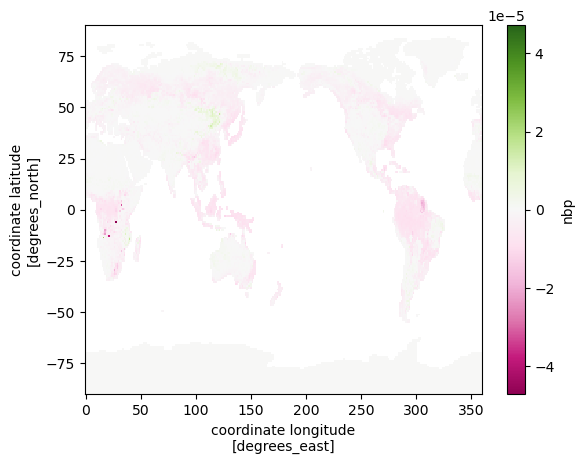

In [42]:
# the stripes in the CESM output are an artefact of the postprocessing. 
#The original variable named file looks fine, but the version that was uploaded to NIRD and then downloaded has stripes
# need to figure out how to fix that

ds=xr.open_dataset('/glade/u/home/aswann/scratch/flat10/TimeSeries/b.e21.B1850.f09_g17.FLAT10-cdr.001.clm2.h0.ts.allyears.nbp.nc')

(ds.nbp[-23:-1,:,:].mean(dim='time')-ds.nbp[0:23,:,:].mean(dim='time')).plot(cmap='PiYG')

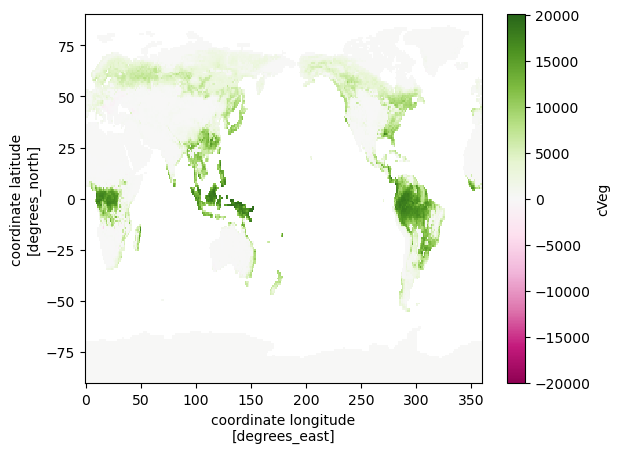

In [89]:
#/glade/campaign/cgd/tss/people/aswann/flat10/CESM2/flat10/b.e21.B1850.f09_g17.FLAT10-esm.001.clm2.h0.ts.allyears.cVeg.nc

ds=xr.open_dataset('/glade/campaign/cgd/tss/people/aswann/flat10/CESM2/flat10/b.e21.B1850.f09_g17.FLAT10-esm.001.clm2.h0.ts.allyears.nbp.nc', use_cftime=True)
ds2=xr.open_dataset('/glade/campaign/cgd/tss/people/aswann/flat10/CESM2/flat10/b.e21.B1850.f09_g17.FLAT10-esm.001.clm2.h0.ts.allyears.cVeg.nc', use_cftime=True)

ds3=xr.merge([ds, ds2])

ds4=ds3.copy(deep=True)

(ds4.cVeg[-23:-1,:,:].mean(dim='time')-ds4.cVeg[0:23,:,:].mean(dim='time')).plot(cmap='PiYG')

ModuleNotFoundError: No module named 'xcollection'

<xarray.Dataset>
Dimensions:      (time: 2520, hist_interval: 2, lon: 288, lat: 192)
Coordinates:
  * time         (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
  * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds  (time, hist_interval) object 0000-12-31 23:30:00 ... 0211-01...
    nbp          (time, lat, lon) float32 ...
    cVeg         (time, lat, lon) float32 ...
Attributes: (12/101)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Tue May 14 13:33:44 2024: ncre...
    source:                                    Community Land Model CLM4.0
    hostname:                                  derecho
    ...                                        ...
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    NCO:                                       netCDF Operators version 5.1.9...

In [38]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
modellist=['NorESM2-LM']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            filenamelist= glob.glob(searchpath)
            
            dsmerge_f=xr.open_mfdataset(filenamelist)

            # merge all variables into one dataset
            # this could potentially be done with xr.open_mfdatset all in one go, but for now:
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

        if model !='GISS_E2.1':
            # add  land fraction and area of gridcells to the dataframe
            dsmerge_v = xr.merge([dsmerge_v, areacella, landfrac],compat='override')
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +' = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

ACCESS_flat10 = dsmerge_v.copy(deep=True)
ACCESS_flat10_zec = dsmerge_v.copy(deep=True)
ACCESS_flat10_cdr = dsmerge_v.copy(deep=True)


In [87]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
modellist=['NorESM2-LM']
modellist_safe = ['NorESM2']

searchpathappend=[]

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            
            #filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points

        
        searchpath= outputdir +model +'/' +run +'/*Lmon' +'*.nc'
        dsmerge_v = xr.open_mfdataset(searchpath, use_cftime=True)


        if model !='GISS_E2.1':
            # add  land fraction and area of gridcells to the dataframe
            dsmerge_v = xr.merge([dsmerge_v, areacella, landfrac],compat='override')

        searchpathappend=[]
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +'_mf = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

NorESM2_flat10_mf = dsmerge_v.copy(deep=True)


MergeError: conflicting values for variable 'type' on objects to be combined. You can skip this check by specifying compat='override'.

In [238]:
data_dict = {
    'CESM2_flat10': CESM2_flat10,
    'CESM2_flat10_zec': CESM2_flat10_zec
}

data_dict['CESM2_flat10_cdr'] = CESM2_flat10_cdr

In [239]:
data_dict

{'CESM2_flat10': <xarray.Dataset>
 Dimensions:      (time: 2520, hist_interval: 2, lon: 288, lat: 192)
 Coordinates:
   * time         (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
   * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * lat          (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
 Dimensions without coordinates: hist_interval
 Data variables:
     time_bounds  (time, hist_interval) object 0000-12-31 23:30:00 ... 0211-01...
     cVeg         (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
     cLitter      (time, lat, lon) float32 ...
     cSoil        (time, lat, lon) float32 ...
     nbp          (time, lat, lon) float32 ...
 Attributes: (12/101)
     title:                                     CLM History file information
     comment:                                   NOTE: None of the variables ar...
     Conventions:                               CF-1.0
     history:                              

In [ ]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
modellist=['CESM2']#['NorESM2-LM']
modellist_safe = ['CESM2']#['NorESM2']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

        if model !='GISS_E2.1':
            # add  land fraction and area of gridcells to the dataframe
            dsmerge_v = xr.merge([dsmerge_v, areacella, landfrac])#,compat='override')
        
        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_' +runlist[r] +' = dsmerge_v.copy(deep=True)'
        print(exestr)
        exec(exestr)
        

In [ ]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        print(model +' getting grid info')
        # get land fraction
        filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
        landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

        # create datasets for each model + experiment combination, each containing all variables
        exestr= modellist_safe[m] +'_areacella = areacella.copy(deep=True)'
        exec(exestr)

        exestr= modellist_safe[m] +'_landfrac = landfrac.copy(deep=True)'
        exec(exestr)